In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import ExoOxygen as eo
from scipy import interpolate
from astropy.io import fits
from astropy import constants as c
from PyAstronomy import pyasl
from spectres import spectres
from num2tex import num2tex
import astropy.constants as const
import astropy.units as u
from scipy.signal import argrelextrema
import multiprocessing as mp

In [2]:
#####################
# Display and backend
#####################
plt.style.use("default") # Reset to default before layering on any changes
FIG_LARGE = (12, 8) # Default plot figure size for large figures
%config InlineBackend.figure_format = "retina" # Crisp retina display on macs
#%matplotlib qt5 

################
# Theme settings
################
notebook_mode = "paper" # (paper | dark)
sns.set(palette="colorblind", color_codes=True, context="talk")

if notebook_mode.lower() == "paper":
    tick_params = {
        "xtick.top":True,
        "xtick.direction":"in",
        "ytick.right":True,
        "ytick.direction":"in",
        "axes.spine.right":True
    }
    sns.set_style("ticks", tick_params)
    params = {
        "axes.formatter.limits":(-3, 7),
        "xtick.major.size":14,
        "ytick.major.size":14,
        "xtick.minor.visible":True,
        "ytick.minor.visible":True,
    }
    plt.rcParams.update(params)

elif notebook_mode.lower() == "dark":
    plt.style.use("cyberpunk")

else:
    plt.style.use("default")

# Motivation

In this notebook, we explore the feasability of detecting Oxygen on an Earth-like planet orbiting stars of various spectral types. The end product is a plot of the number of trasnits it would take to detect such a planet.



## 1) Data Preparation
 
All our data is retrieved from the following:

#### For: Star
Source: http://phoenix.astro.physik.uni-goettingen.de/?page_id=15   
Units: wav (Å), flux ($erg/s/cm^2/cm)$   
Filename structure: lte<T_eff>-<logg>-<[Fe/H]>...-HiRes.fits
Note: according to http://phoenix.astro.physik.uni-goettingen.de/?page_id=10 there is typo in header. Mass should be in grams and luminosity in erg/s

    
    
#### For: Tellurics   
Source: http://etimecalprev.hq.eso.org/observing/etc/data/SM-01_5000_old/SM-01_5000/sm-01_mod2/data/lib/   
Units: wav (um), flux (normalized)
Filename structure: pwv_R<resolution>k_airmass<airmass>/LBL_A<airmass>0_s0_w<pwv>_R0<resolution>_<spectype>
Note: abbreviations here: http://etimecalprev.hq.eso.org/observing/etc/data/SM-01_5000_old/SM-01_5000/sm-01_mod2/data/libstruct_pwv.dat


#### For: Planet   
Source: Mercedes HITRAN data   
Units: wav (nm), flux (normalized)   
Filename structure: O2_<resolution>.txt

In [3]:
## SET SYSTEMATIC VELOCITY
v_system = 20

In [4]:
# Load Data
# For: Star
flux_star = fits.getdata("./data/PHOENIX/lte03600-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
flux_star_norm = flux_star / np.max(flux_star)
wav_star = fits.getdata(f"./data/PHOENIX/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits") * 1e-8 # in cm

# For: Tellurics
data_tell = fits.getdata(f"./data/Tellurics/pwv_R300k_airmass1.0/LBL_A10_s0_w005_R0300000_T.fits")
wav_tell, tell = data_tell["lam"] * 1e-4 , data_tell["trans"] /  np.max(data_tell["trans"])


# For: Planet
names = ["Wavnum", "Wav", "Trans"] # [Wavenumber (cm-1), Wavlength (nm), T]
pd_kwargs = {
    "names":names,
    "sep":" ",
    "skiprows":4,
    "skipinitialspace":True,
}
exo_df = pd.read_csv('./data/ExoplanetO2/O2_3E5.txt', **pd_kwargs)
wav_planet, planet = exo_df["Wav"][::-1].values * 1e-7, exo_df["Trans"][::-1].values / np.max(exo_df["Trans"][::-1].values)  # Reverse so wavelength increasing like the others



#### Plot raw data: INSERT LATER

### Resample

Note that the star, planet, and telluric data are all arrays of different sizes (which makes sense since they all come from different sources). Therefore, we need to 'resample' the arrays so that they're resized with the same number of points (some interpolation is involved here). This step is essential in order to perform further calculations with the data. 

In [5]:
# Define resolution to compute in particular wavelength band
wav_band = np.array([759*1e-7, 772*1e-7]) # cm
R = 3e5 

# Make Dataframe
data = pd.DataFrame({})


# Resample data so they all have the same number of points
data['resampled_star_wav'], data['resampled_star_flux'] = eo.resample(
        wav_star,
        wav_band,
        R,
        flux_star_norm,
    )

data['resampled_tell_wav'], data['resampled_tell'] = eo.resample(
        wav_tell,
        wav_band,
        R,
        tell,
    )

data['resampled_planet_wav'], data['resampled_planet'] = eo.resample(
        wav_planet,
        wav_band,
        R,
        planet,
    )


#### Plot resampled data

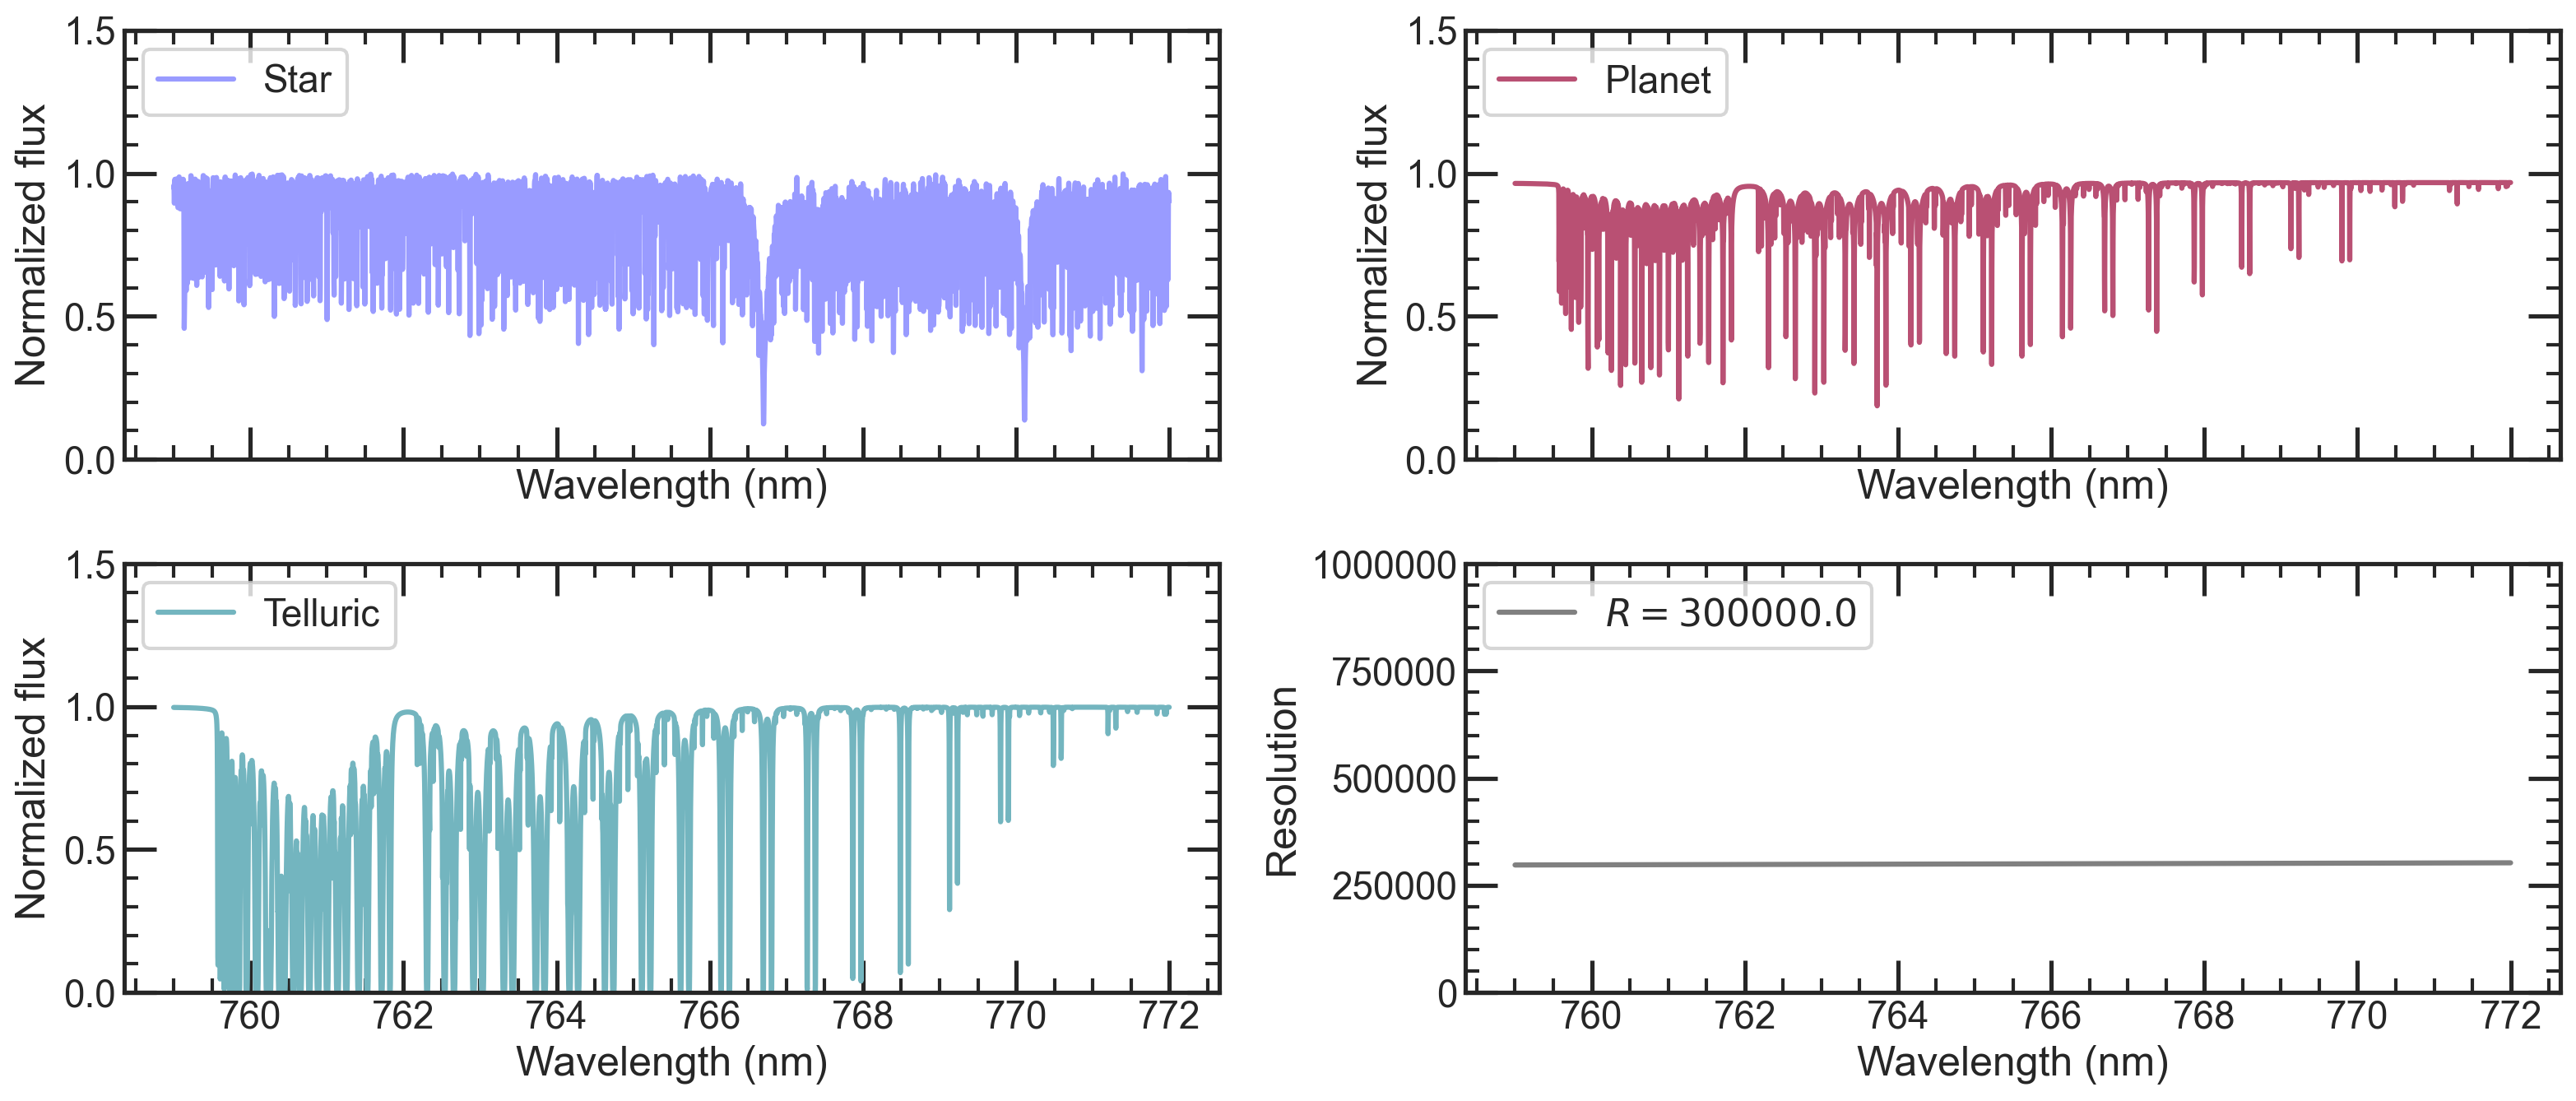

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 7), sharex=True)
ax_STP, ax_res = axes.flatten()[:3], axes.flatten()[-1]

###########
# STP plots
###########
colors = ['#999BFF', '#B95073', '#73B5BF']
colnames = ['star_flux', 'planet', 'tell']
plotnames = ['Star', 'Planet', 'Telluric']
wav = data['resampled_star_wav'] * 1e7 # Just use star wavelenght since we're using the same range for everything
for ax, n, c, l in zip(ax_STP, colnames, colors, plotnames):
    ax.plot(wav, data[f'resampled_{n}'], color=c, label=l)
    # Make some space at the top for the legend
    [ax.set_ylim(0, 1.5) for ax in ax_STP]
    ax.legend(loc=2, ncol=3)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Normalized flux")
    
#################
# Resolution plot
#################
res = eo.get_R(data['resampled_star_wav'] * 1e7)
ax_res.plot(wav, res, c='grey', label=f"$R = {R}$")

ax_res.yaxis.set_ticks(np.linspace(0, 1e6, 5))
ax_res.legend(loc=2, ncol=3)
ax_res.set_xlabel("Wavelength (nm)")
ax_res.set_ylabel("Resolution")

fig.tight_layout()


### Doppler Shift

Finally, we'll want to be able to Doppler shift our S and P spectra, based on the systemic velocity of a particular system. This can be done with `pyasl.dopplerShift`, which we will use with an example velocity of $20\text{ km/s}$ and $R = 3\times10^5$. (Note that the telluric isn't Doppler shifted here because the Earth's atmosphere isn't shifted with respect to us).

In [7]:
## RENORMALIZE JUST IN CASE
data['resampled_planet_norm'] = data['resampled_planet'] / data['resampled_planet'].max()
data['resampled_star_norm'] = data['resampled_star_flux'] / data['resampled_star_flux'].max()

In [8]:
v_system = 20

data['shifted_star_flux'], _ = pyasl.dopplerShift(
                                                data['resampled_star_wav'].to_numpy(), 
                                                data['resampled_star_norm'].to_numpy(), 
                                                v_system, 
                                                edgeHandling="firstlast",
                                                )


data['shifted_planet'], _ = pyasl.dopplerShift(
                                                data['resampled_planet_wav'].to_numpy(), 
                                                data['resampled_planet_norm'].to_numpy(), 
                                                v_system, 
                                                edgeHandling="firstlast",
                                                )


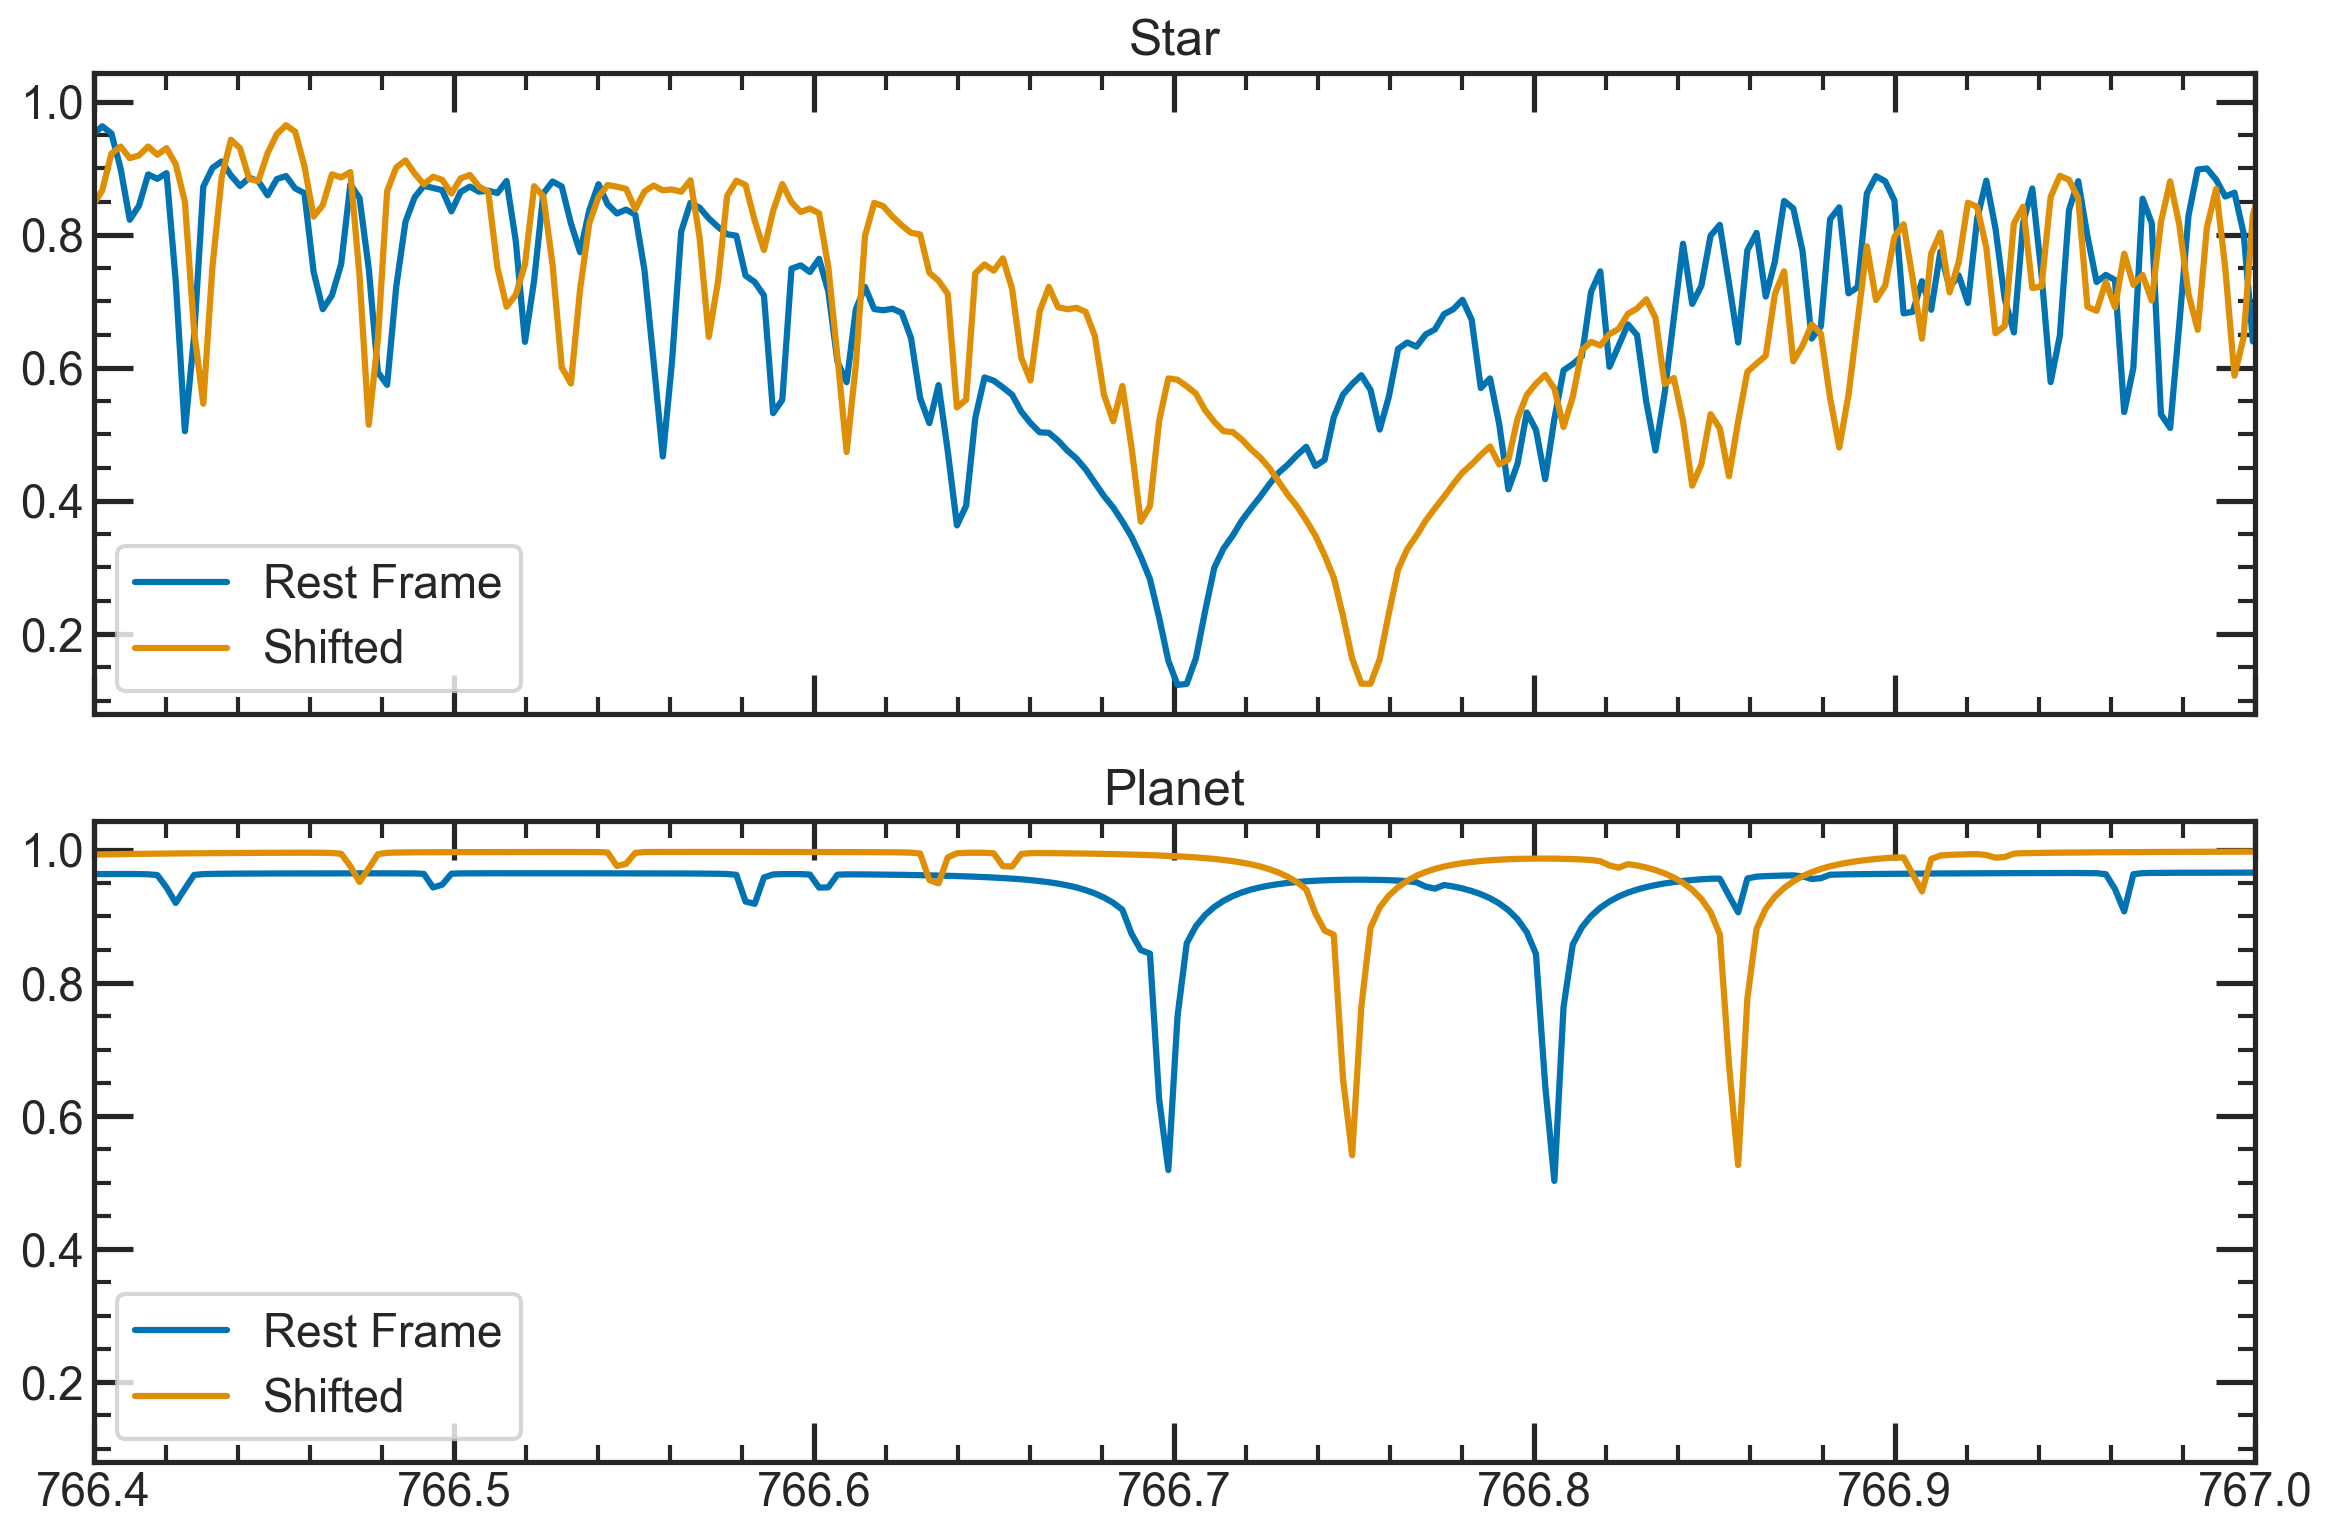

In [9]:
######
# Plot
######
fig, axes = plt.subplots(2, 1, figsize=FIG_LARGE, sharex=True, sharey=True)

colors = ['#999BFF', '#B95073']
colnames = ['star_flux', 'planet']
plotnames = ['Star', 'Planet']
wav = data['resampled_star_wav'] * 1e7 # Just use star wavelength since we're using the same range for everything
for ax, n, l in zip(axes, colnames, plotnames):
    flux = data[f'resampled_{n}']
    flux_shifted = data[f'shifted_{n}']
    ax.plot(wav, flux, label="Rest Frame")
    ax.plot(wav, flux_shifted, label="Shifted")
    ax.set_title(l)
    ax.legend(loc=3)
    
axes[-1].set_xlim(766.4, 767.0)

fig.tight_layout()

## 2) Create Model Spectrum

In order to make the model spectrum observed by a telescope (ground-based), we need to add the contribution from the star, planet atmosphere, and Earth's atmopshere. 

First, let's some important bounds: planet radius, star radius, and planet atmosphere size.

In [10]:
# For an Earth like planet:
R_p = const.R_earth.cgs
R_a = (80 * u.km).to(u.cm) # We'll assume the Earth's atmosphere goes from 5 to 85 km

# Orbiting an M dwarf (let's say 0.49 times the solar radius ~ M1V star)
R_s = 0.26 * const.R_sun.cgs


Now, we can calculate the fluxes with the in and out of transit information. The amount of stellar flux received in transit is the star flux minus the flux blocked by the planet. Then:

In [11]:
ratio_blocked = ((np.pi * (R_p + R_a)**2) / (np.pi * (R_s)**2)) 
data['F_star_received'] = data['shifted_star_flux'] - data['shifted_star_flux'] * ratio_blocked

Then we can find $\epsilon$, the ratio of the planet's atmopshere area to the star's area:   

\begin{aligned}
\epsilon=\frac{{A_{atmosphere, planet}}}{A_{star}} &=\frac{\left(R_{a}+R_{p}\right)^{2} \pi  -R_{p}^{2} \pi}{R_{s}^{2} \pi} \\
&=\frac{\left(R_{a}^{2}+R_{p}^{2}+2 R_{a p}\right) \pi-R_{p}^{2} \pi}{R_{s}^{2} \pi} \\
&=\frac{R_{a}{ }^{2}+2 R_{a} R_{p}}{R_{s}{ }^{2}}
\end{aligned}

Using our parameters, we get:


In [12]:
eps = (R_a**2 + 2*R_a*R_p) / (R_s **2)
print(eps) 

3.138598475951698e-05


Now with $\epsilon$, we can include how much of the starlight is masked by the planet's atmosphere.

In [13]:
data['F_star_planet'] = data['F_star_received']  + eps*data['F_star_received']*data['shifted_planet']

Let's say that the observed planetary spectrum $P_{obs}$ is the ratio of the in-transit flux received minus out of transit flux received, with telluric incorporated.

In [14]:
data['P_obs'] = ( data['F_star_planet'] - data['F_star_received'] ) 

Local maxima are [-24  -2   2   8  20]


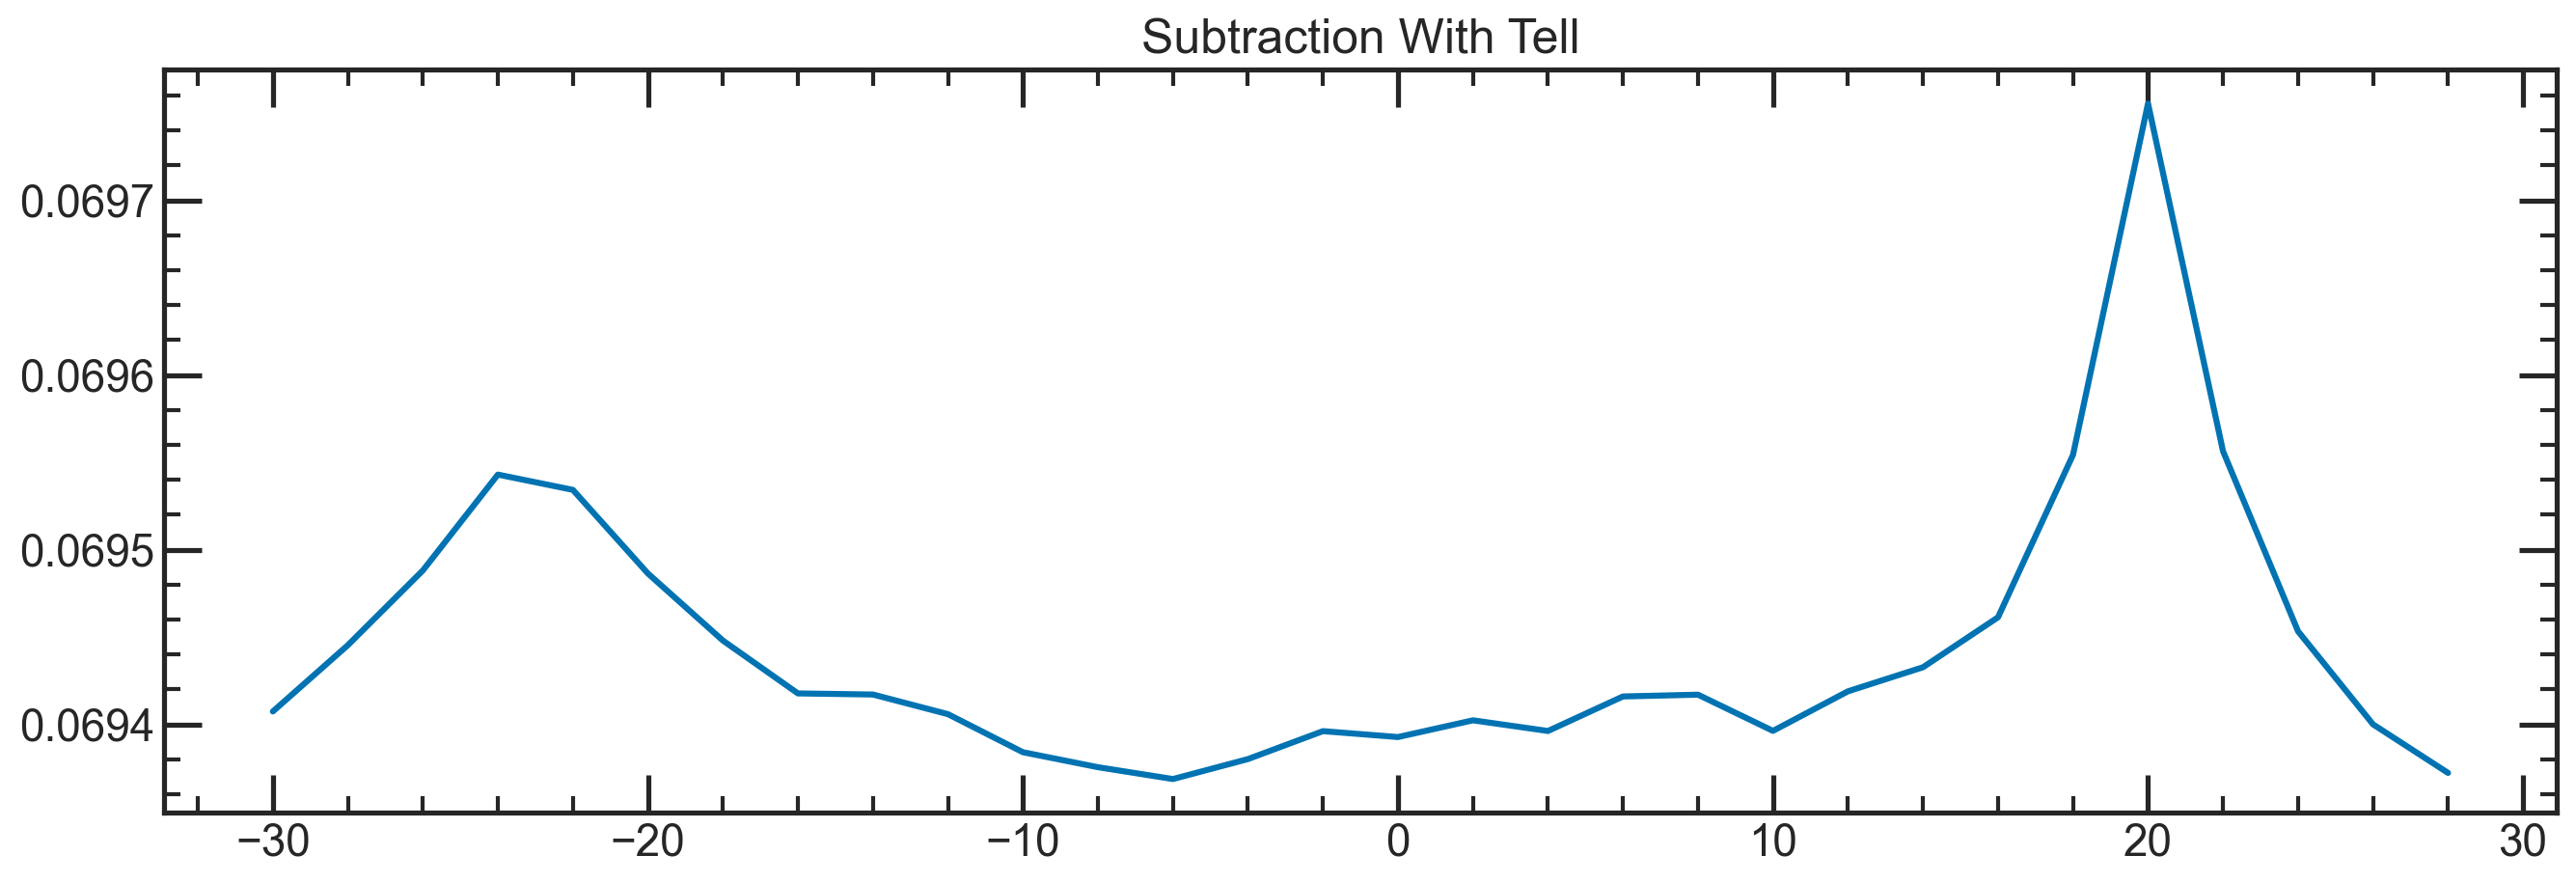

In [15]:
rv_sub, cc_sub = pyasl.crosscorrRV(
                 data['resampled_planet_wav'].to_numpy(), data['P_obs'].to_numpy(), # spectrum 1
                 data['resampled_planet_wav'].to_numpy(), data['resampled_planet'].to_numpy(), # spectrum 2
                 -30, # lower bound velocity shift
                 30,  # upper bound velocity shift
                 2, # velocity increment,
    skipedge = 1000
             )

maxind_sub = np.argmax(cc_sub)
v_max_sub = rv_sub[maxind_sub]

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1,1,1)
plt.plot(rv_sub, cc_sub, label="RV")
plt.title('Subtraction With Tell')

# Code to easily find local maxima
print(f"Local maxima are {rv_sub[argrelextrema(cc_sub, np.greater)]}")

### Add Noise: This is just a test, so we'll make a new df

In [16]:
sigma_w = 1e-10
spectra_flux = 10000

data_noise = data

# In transit
data_noise['in_transit_flux'] = data_noise['F_star_planet'] * spectra_flux
data_noise['in_transit_noise'] = np.random.uniform(low = -1, high = 1, size = data_noise['F_star_planet'].size) * sigma_w
data_noise['F_star_planet_noise'] = (data_noise['in_transit_flux'] + data_noise['in_transit_noise']) 

# Out of transit
data_noise['out_transit_flux'] = data_noise['F_star_received'] * spectra_flux
data_noise['out_transit_noise'] = np.random.uniform(low = -1, high = 1, size = data_noise['F_star_received'].size) * sigma_w
data_noise['F_star_noise'] = (data_noise['out_transit_flux'] + data_noise['out_transit_noise']) 

# P Obs with noise
data_noise['P_obs_noise'] = (data_noise['F_star_planet_noise'] - data_noise['F_star_noise']) 

Local maxima are [-24  -2   2   8  20]


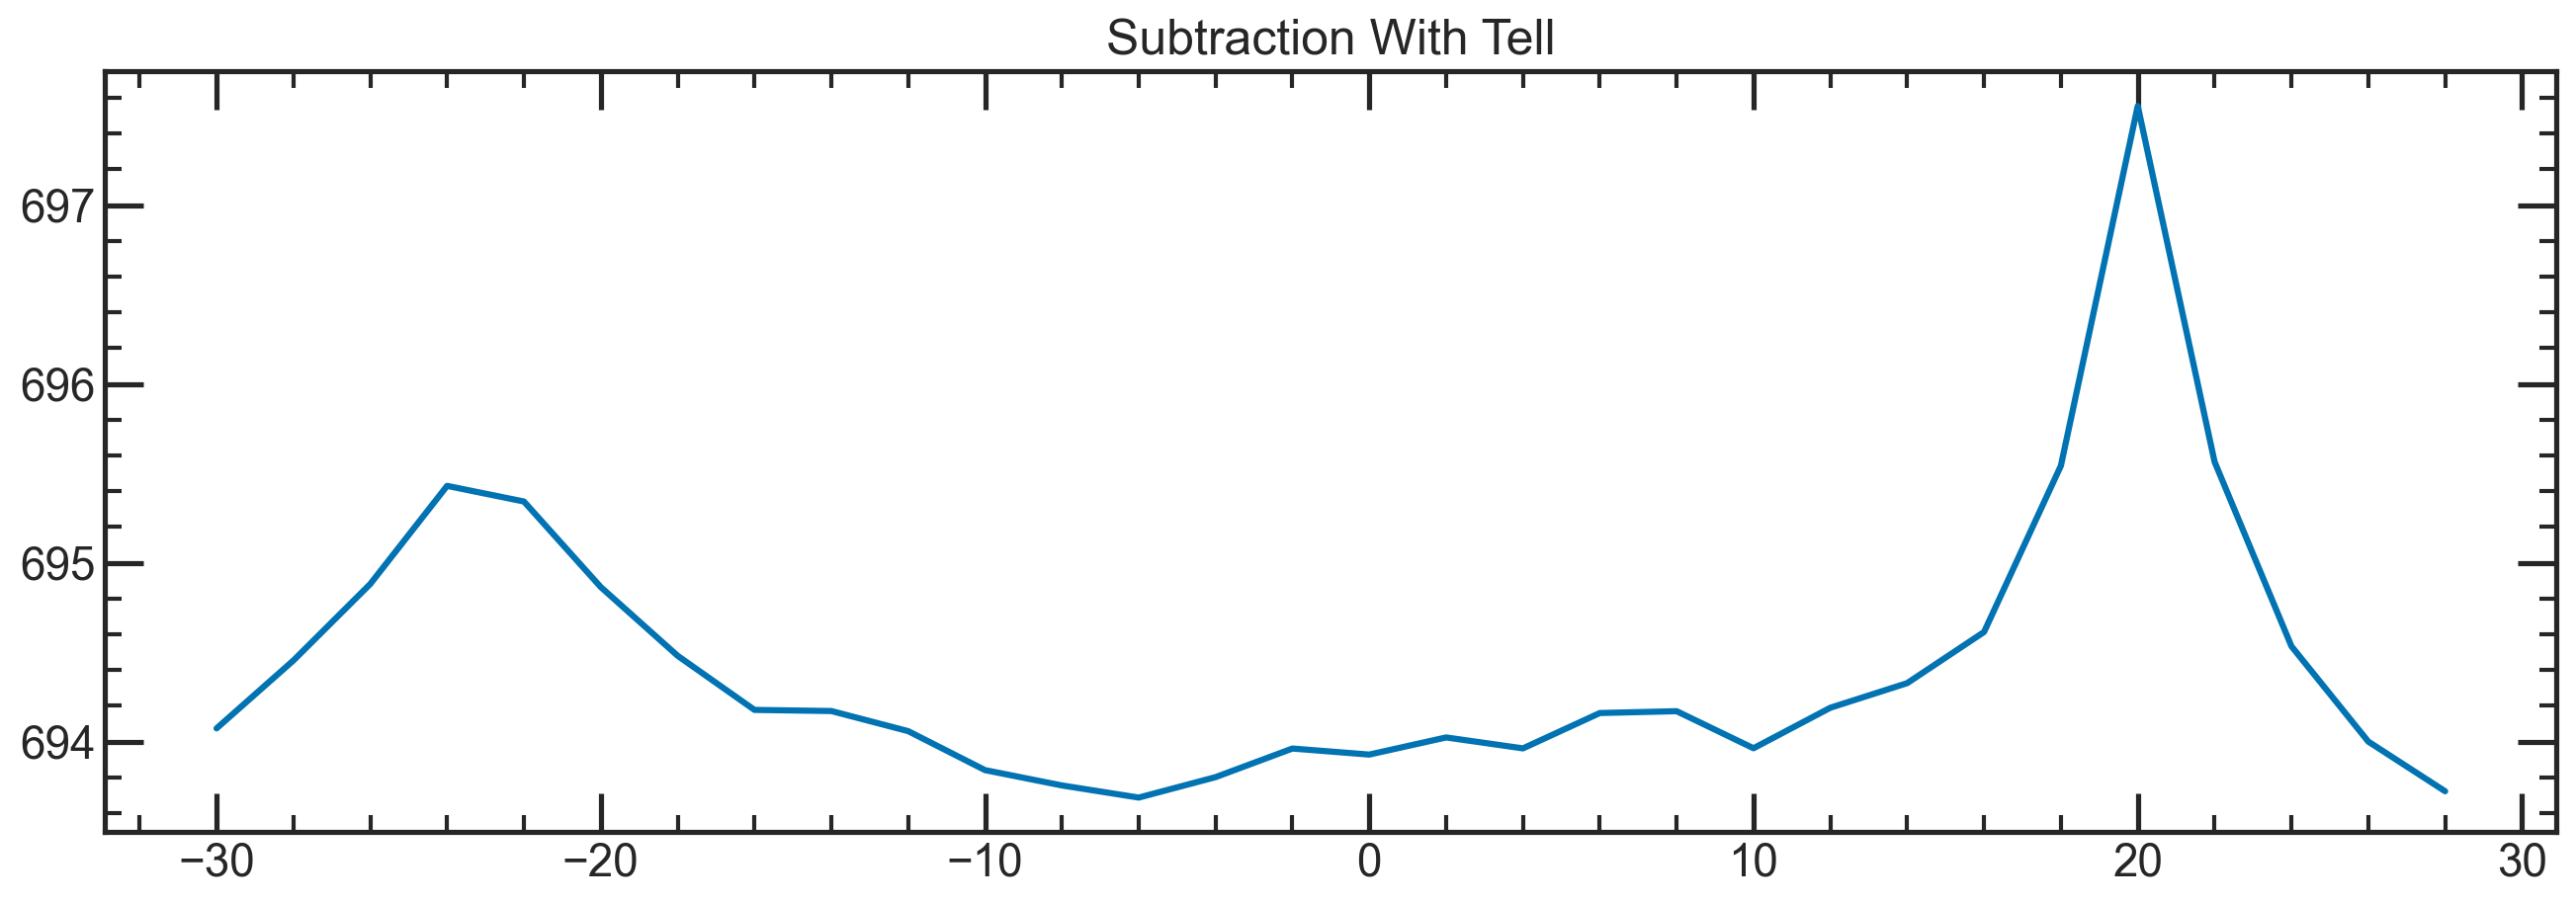

In [17]:
rv_sub_noise, cc_sub_noise = pyasl.crosscorrRV(
                 data['resampled_planet_wav'].to_numpy(), data_noise['P_obs_noise'].to_numpy(), # spectrum 1
                 data['resampled_planet_wav'].to_numpy(), data['resampled_planet'].to_numpy(), # spectrum 2
                 -30, # lower bound velocity shift
                 30,  # upper bound velocity shift
                 2, # velocity increment,
    skipedge = 1000
             )

maxind_sub_noise = np.argmax(cc_sub_noise)
v_max_sub_noise = rv_sub_noise[maxind_sub_noise]

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1,1,1)
plt.plot(rv_sub_noise, cc_sub_noise, label="RV")
plt.title('Subtraction With Tell')

# Code to easily find local maxima
print(f"Local maxima are {rv_sub[argrelextrema(cc_sub, np.greater)]}")


In [18]:
# # Figure out how to keep both > and < 0 and then choose whichever is higher
# peaks = rv_sub[argrelextrema(cc_sub, np.greater)]
# peaks[(peaks > 0) or (peaks < 0)]

### Now Bootstrap


# assume 1 transit = 1e8 photons 

do bootstraping 1000 times, count how many times out of 1000 do we find 20 (FAP in percentage). See where we get to 3 sigma. Then just plot it. 

We want to see if going to brighter spectral types (bluer) would mean that it's better to use the B band over the A band, or both of them combined.

In [19]:
sigma_convert = pd.read_csv('sigma_convert.csv')

# Sigma interpolation function
x =  sigma_convert['Significance'].tolist()
y = sigma_convert['Sigma'].tolist()
f = interpolate.interp1d(x, y, fill_value='extrapolate')

## Before Optimzation

In [20]:
# import time
# start_time = time.time()

# N_transits =  np.linspace(1, 100, 100, dtype = int).tolist() # Number of transits: 10 different values from 10 to 30
# # N = 10 # (just do for 10 transits for now)
# M = 1000 # Number of datales to make for each transit
# N_photons = 1e8
# system_v = 20 
# delta_v = 0.5 # Change in velocity (the increment when dataling doppler shift)
# faps = []

# for N in N_transits:

#     CCF_vals = []

#     # Add noise
#     N_photons_pertransit = N*N_photons
#     sigma_w = 1/np.sqrt(N_photons_pertransit)

#     # Generate M datales and calculate CCF
#     for i in range(M):

#         # In transit
#         data['in_transit_flux'] = data['F_star_planet'] 
#         data['in_transit_noise'] = np.random.uniform(low = -1, high = 1, size = data['F_star_planet'].size) * sigma_w
#         data['F_star_planet_noise'] = (data['in_transit_flux'] + data['in_transit_noise']) 

#         # Out of transit
#         data['out_transit_flux'] = data['F_star_received'] 
#         data['out_transit_noise'] = np.random.uniform(low = -1, high = 1, size = data['F_star_received'].size) * sigma_w
#         data['F_star_noise'] = (data['out_transit_flux'] + data['out_transit_noise']) 

#         # P Obs with noise
#         data['P_obs_noise'] = (data['F_star_planet_noise'] - data['F_star_noise']) 


#         # Perform CCF
#         rv_sub_noise, cc_sub_noise = pyasl.crosscorrRV(
#                  data['resampled_planet_wav'].to_numpy(), data['P_obs_noise'].to_numpy(), # spectrum 1
#                  data['resampled_planet_wav'].to_numpy(), data['resampled_planet'].to_numpy(), # spectrum 2
#                  -30, # lower bound velocity shift
#                  30,  # upper bound velocity shift
#                  2, # velocity increment
#                  skipedge = 1000
#              )



#         CCF_val = rv_sub_noise[np.argmax(cc_sub_noise)]
#         CCF_vals.append(CCF_val)

#     CCF_vals_array = np.array(CCF_vals)
#     m = len(CCF_vals_array[(CCF_vals_array <= (system_v + delta_v)) & ((system_v - delta_v) <= CCF_vals_array)])
#     FAP = m/M
#     faps.append(FAP)

# print("--- %s seconds ---" % (time.time() - start_time))

--- 584.2903969287872 seconds ---


## After Optimzation

In [21]:
%%writefile calculate.py
import numpy as np
from PyAstronomy import pyasl

M = 1000 # Number of datales to make for each transit
N_photons = 1e8
system_v = 20 
delta_v = 0.5 # Change in velocity (the increment when dataling doppler shift)

def calculate(args):
    N, data = args[0], args[1]
    CCF_vals = []

    # Add noise
    N_photons_pertransit = N*N_photons
    sigma_w = 1/np.sqrt(N_photons_pertransit)

    # Generate M datales and calculate CCF
    for i in range(M):

        # In transit
        data['in_transit_flux'] = data['F_star_planet'] 
        data['in_transit_noise'] = np.random.uniform(low = -1, high = 1, size = data['F_star_planet'].size) * sigma_w
        data['F_star_planet_noise'] = (data['in_transit_flux'] + data['in_transit_noise']) 

        # Out of transit
        data['out_transit_flux'] = data['F_star_received'] 
        data['out_transit_noise'] = np.random.uniform(low = -1, high = 1, size = data['F_star_received'].size) * sigma_w
        data['F_star_noise'] = (data['out_transit_flux'] + data['out_transit_noise']) 

        # P Obs with noise
        data['P_obs_noise'] = (data['F_star_planet_noise'] - data['F_star_noise']) 


        # Perform CCF
        rv_sub_noise, cc_sub_noise = pyasl.crosscorrRV(
                 data['resampled_planet_wav'].to_numpy(), data['P_obs_noise'].to_numpy(), # spectrum 1
                 data['resampled_planet_wav'].to_numpy(), data['resampled_planet'].to_numpy(), # spectrum 2
                 -30, # lower bound velocity shift
                 30,  # upper bound velocity shift
                 2, # velocity increment
                 skipedge = 1000
             )



        CCF_val = rv_sub_noise[np.argmax(cc_sub_noise)]
        CCF_vals.append(CCF_val)

    CCF_vals_array = np.array(CCF_vals)
    m = len(CCF_vals_array[(CCF_vals_array <= (system_v + delta_v)) & ((system_v - delta_v) <= CCF_vals_array)])
    FAP = m/M
    return FAP

Overwriting calculate.py


In [22]:
import time
start_time = time.time()
import multiprocessing as mp

from calculate import calculate

N_transits =  np.linspace(1, 100, 100, dtype = int).tolist() # Number of transits: 10 different values from 10 to 30
# N = 10 # (just do for 10 transits for now)
M = 1000 # Number of datales to make for each transit
N_photons = 1e8
system_v = 20 
delta_v = 0.5 # Change in velocity (the increment when dataling doppler shift)



number_of_cpus_detected = mp.cpu_count()

with mp.Pool(number_of_cpus_detected) as pool:  # Create a threadpool with a thread for each cpu
    fast_faps2 = pool.map(calculate, ((n, data) for n in N_transits))

print("--- %s seconds ---" % (time.time() - start_time))

--- 103.94711875915527 seconds ---


### Look at just the noise

In [ ]:
 # Add noise
N_photons_pertransit = N*N_photons
sigma_w = 1/np.sqrt(N_photons_pertransit)
sigma_r = 1.20*sigma_w # is this right, or is it 1.20 * 1/(N_photons_pertransit**2)
noise = ((sigma_w)**2)/N_photons_pertransit + (sigma_r)**2

In [32]:
%%writefile calculate.py
import numpy as np
from PyAstronomy import pyasl

M = 1000 # Number of datales to make for each transit
N_photons = 1e8
system_v = 20 
delta_v = 0.5 # Change in velocity (the increment when dataling doppler shift)

def calculate(args):
    N, data = args[0], args[1]
    CCF_vals = []

    # Add noise
    N_photons_pertransit = N*N_photons
    sigma_w = 1/np.sqrt(N_photons_pertransit)
    sigma_r = 1.20*sigma_w # is this right, or is it 1.20 * 1/(N_photons_pertransit**2)
    noise = ((sigma_w)**2)/N_photons_pertransit + (sigma_r)**2
    return sigma_w, sigma_r, noise



Overwriting calculate.py


In [34]:
import time
start_time = time.time()
import multiprocessing as mp

from calculate import calculate

N_transits =  np.linspace(1, 100, 100, dtype = int).tolist() # Number of transits: 10 different values from 10 to 30
# N = 10 # (just do for 10 transits for now)
M = 1000 # Number of datales to make for each transit
N_photons = 1e8
system_v = 20 
delta_v = 0.5 # Change in velocity (the increment when dataling doppler shift)



number_of_cpus_detected = mp.cpu_count()

with mp.Pool(number_of_cpus_detected) as pool:  # Create a threadpool with a thread for each cpu
    print(pool.map(calculate, ((n, data) for n in N_transits)))

print("--- %s seconds ---" % (time.time() - start_time))

[(0.0001, 0.00012, 1.44000001e-08), (7.071067811865475e-05, 8.48528137423857e-05, 7.200000024999999e-09), (5.773502691896258e-05, 6.92820323027551e-05, 4.800000011111111e-09), (5e-05, 6e-05, 3.60000000625e-09), (4.4721359549995795e-05, 5.366563145999495e-05, 2.880000004e-09), (4.0824829046386304e-05, 4.898979485566356e-05, 2.400000002777778e-09), (3.779644730092272e-05, 4.5355736761107264e-05, 2.057142859183673e-09), (3.535533905932738e-05, 4.242640687119285e-05, 1.8000000015624997e-09), (3.3333333333333335e-05, 4e-05, 1.6000000012345682e-09), (3.1622776601683795e-05, 3.794733192202055e-05, 1.4400000009999997e-09), (3.015113445777636e-05, 3.618136134933163e-05, 1.3090909099173551e-09), (2.886751345948129e-05, 3.464101615137755e-05, 1.2000000006944444e-09), (2.7735009811261454e-05, 3.328201177351374e-05, 1.1076923082840232e-09), (2.6726124191242442e-05, 3.207134902949093e-05, 1.028571429081633e-09), (2.5819888974716114e-05, 3.0983866769659334e-05, 9.600000004444443e-10), (2.5e-05, 3e-05

In [ ]:
# compute and send to mercedes

Text(0.5, 0, 'Number of Transits')

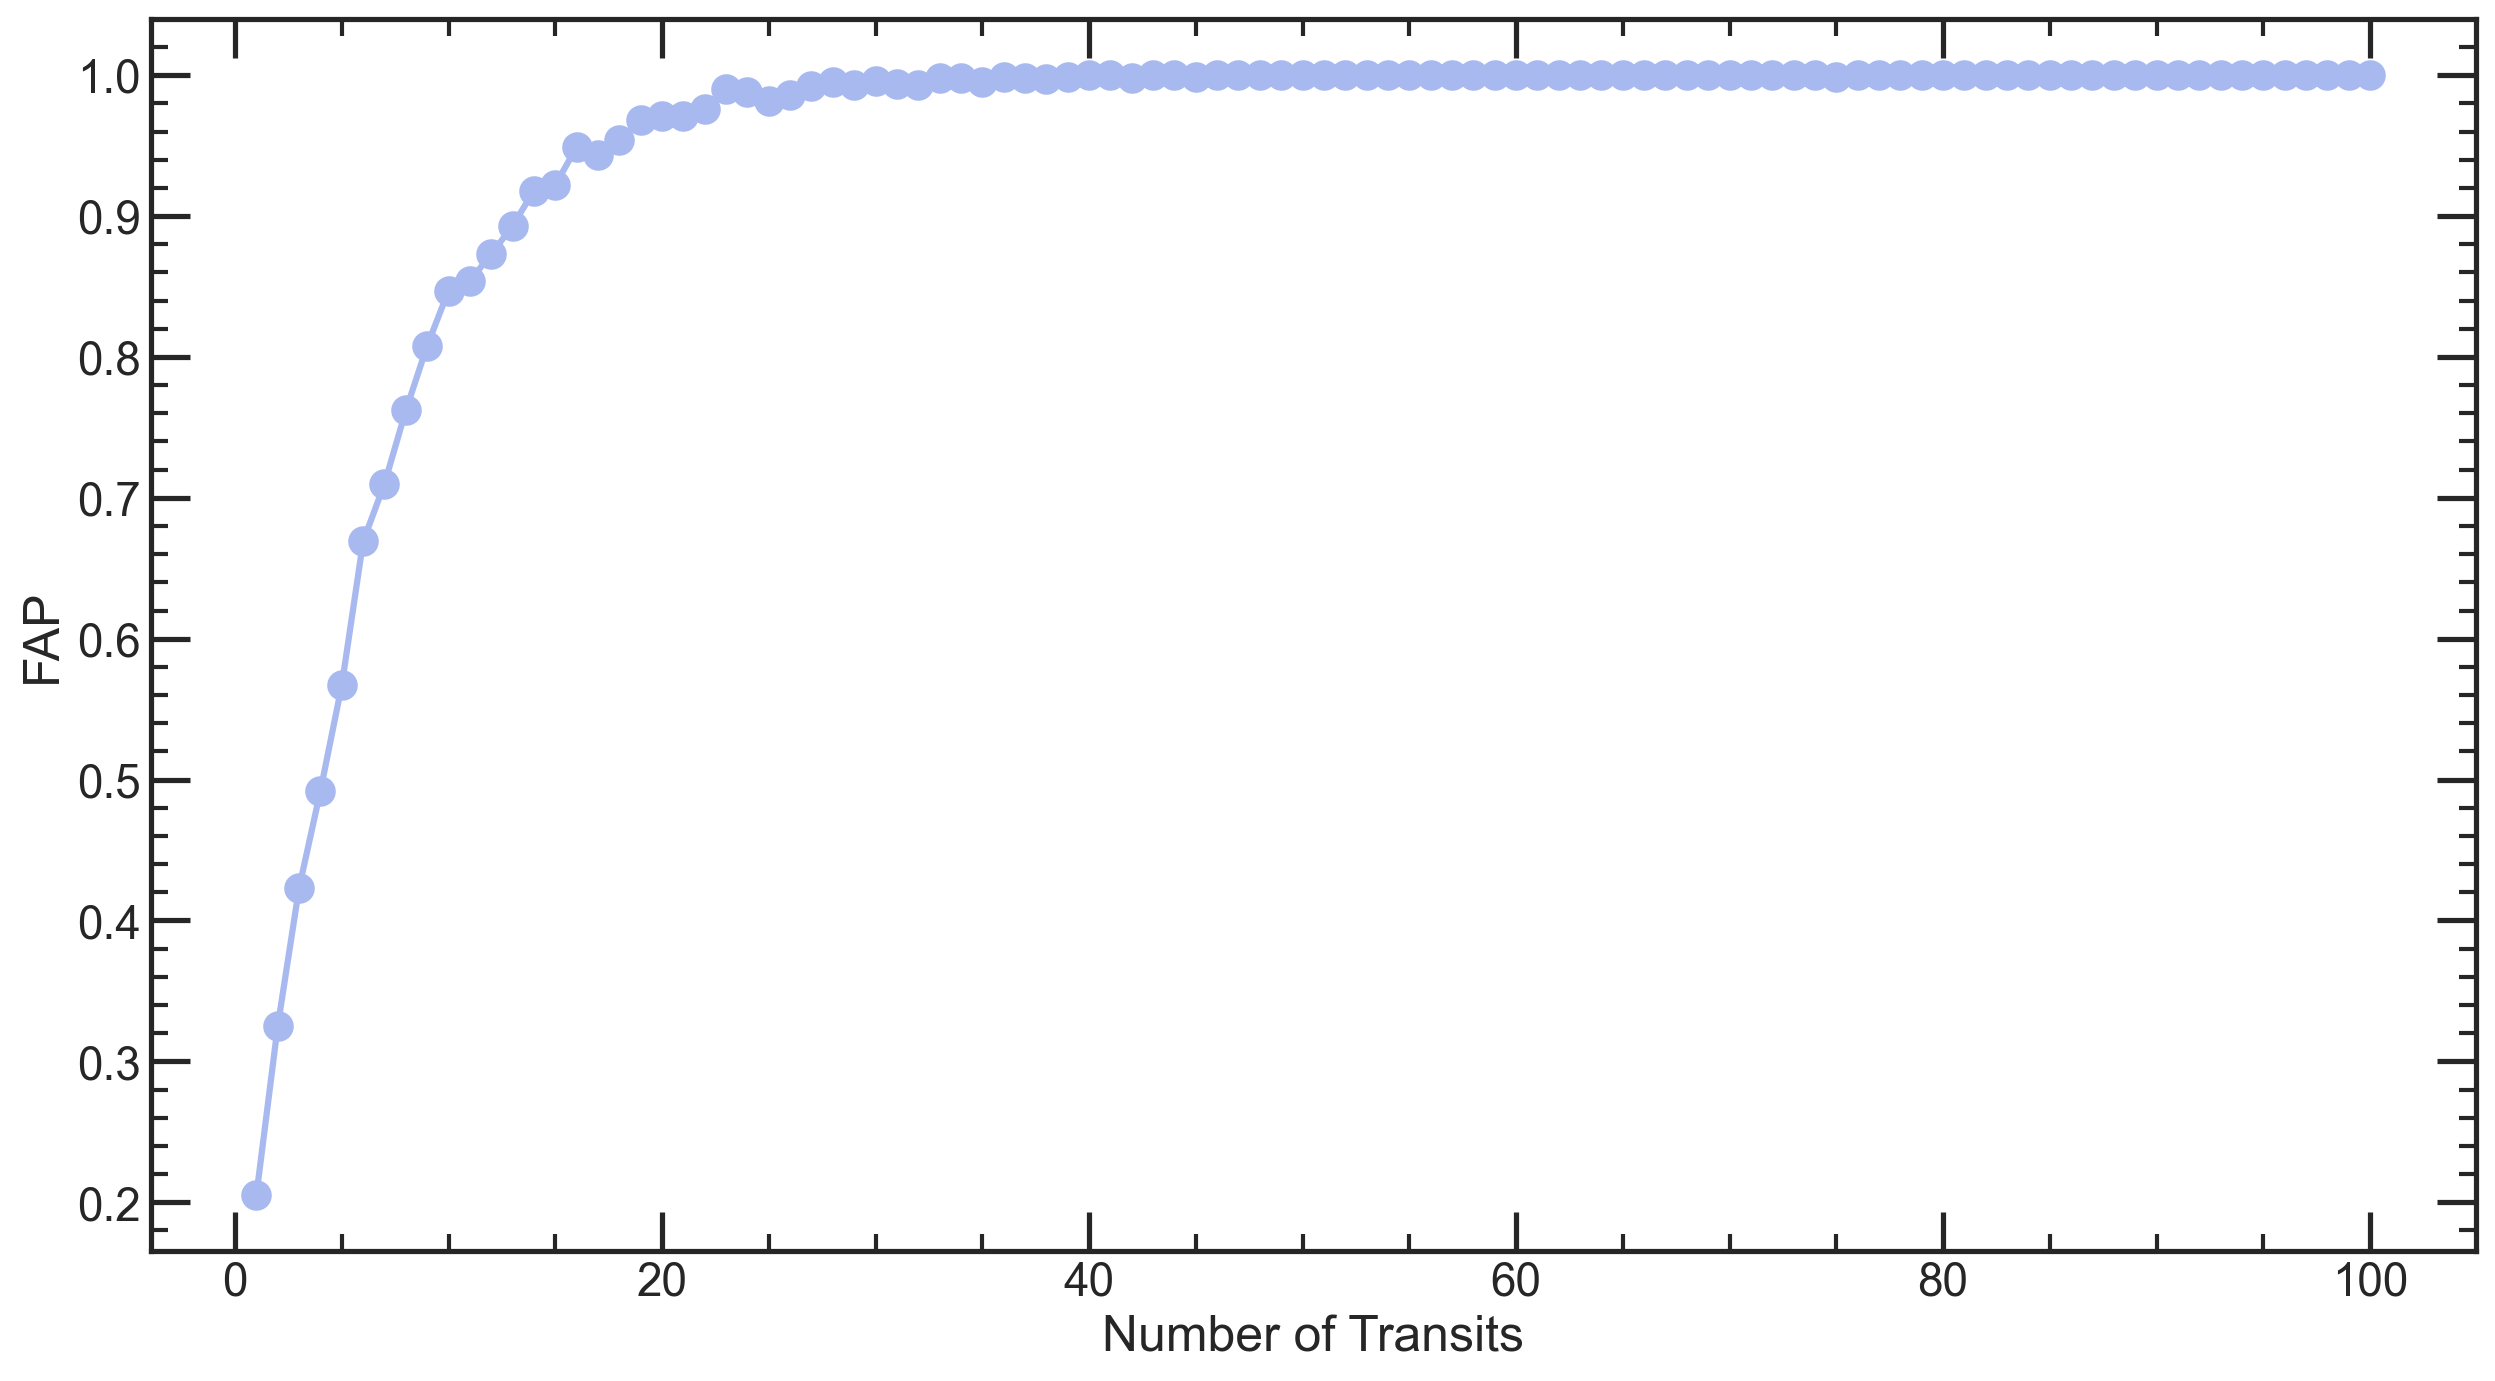

In [23]:
fig = plt.figure(figsize = (15, 8))
plt.plot(N_transits, faps, marker = 'o', ms = 10, color = '#A8B9F0')
plt.ylabel('FAP')
plt.xlabel('Number of Transits')

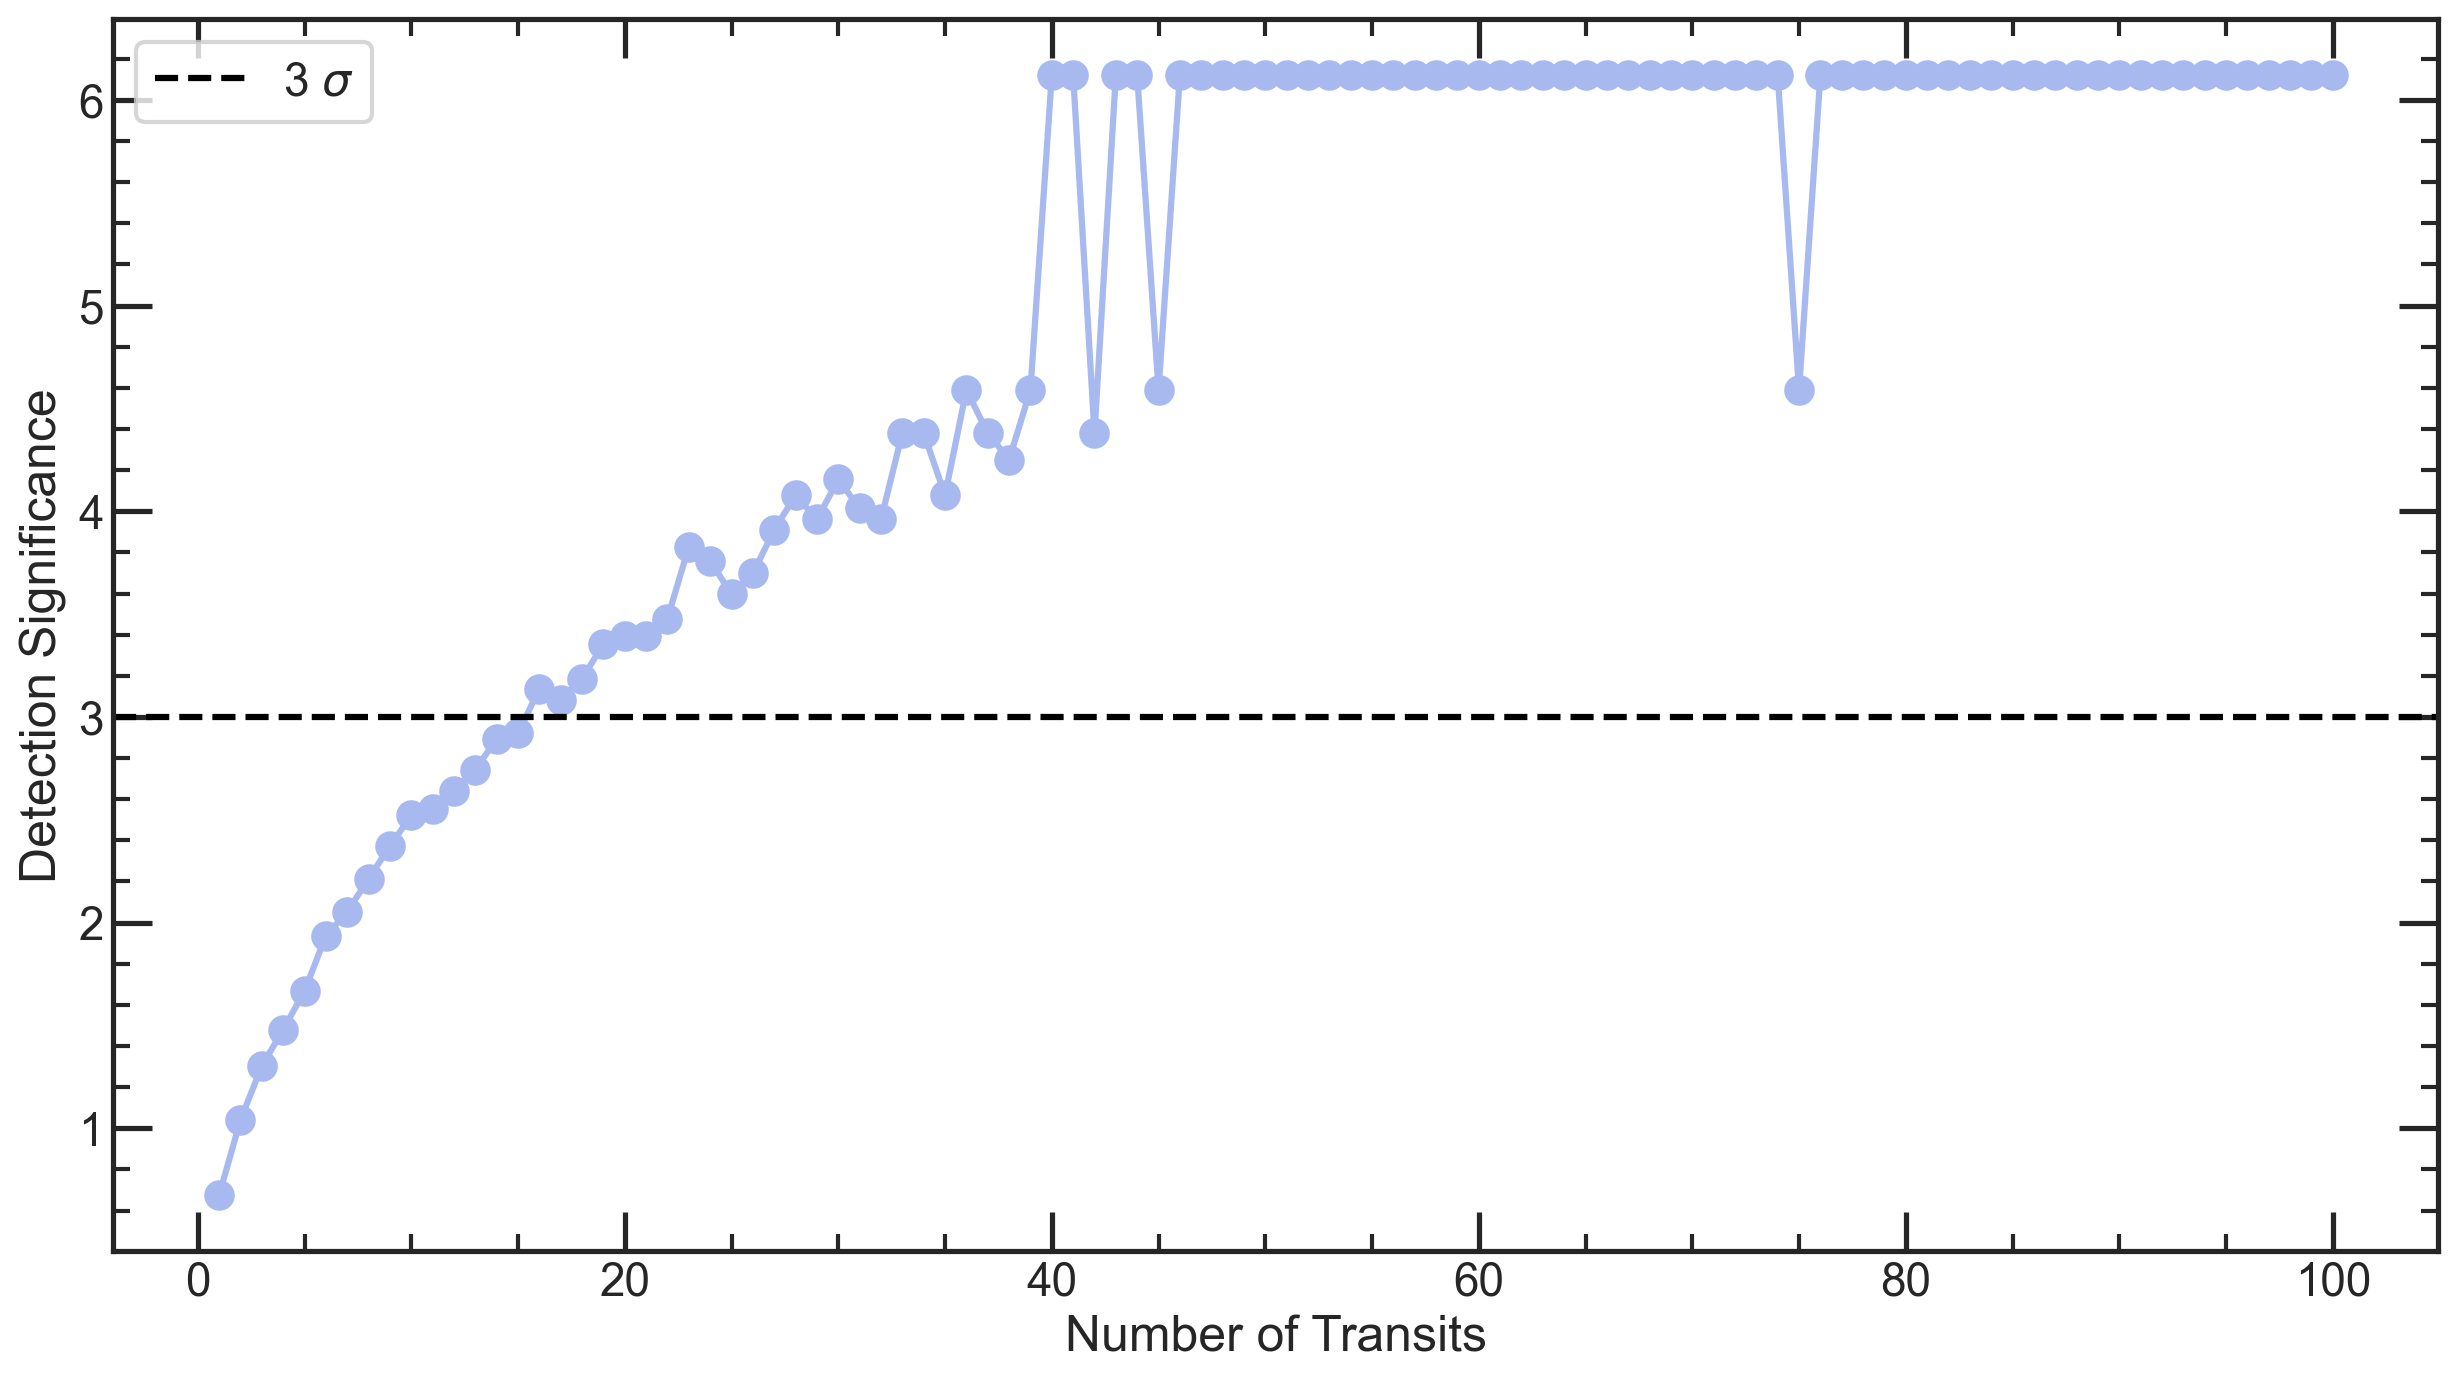

In [24]:
signif = np.array(faps) * 100 # Converting to percentage

# Convert significance to to sigma
sigma = f(signif)

fig = plt.figure(figsize = (15, 8))
plt.plot(N_transits, sigma,  marker = 'o', ms = 10, color = '#A8B9F0')
plt.axhline(3, color = 'black', ls = '--', label = r'3 $\sigma$')
plt.xlabel('Number of Transits')
plt.ylabel('Detection Significance')
plt.legend()

## NOW ADDING RED NOISE

In [76]:
%%writefile calculate.py
import numpy as np
from PyAstronomy import pyasl

M = 1000 # Number of datales to make for each transit
N_photons = 1e8
system_v = 20 
delta_v = 0.5 # Change in velocity (the increment when dataling doppler shift)

def calculate_rednoise(args):
    N_transits, data = args[0], args[1]
    CCF_vals = []

    # Add noise
    N_photons_total = N_transits*N_photons
    sigma_w = 1/np.sqrt(N_photons_total)
    sigma_r = 1.20*sigma_w  
    noise = np.sqrt(((sigma_w)**2)+ (sigma_r)**2)

    # Generate M datasets and calculate CCF
    for i in range(M):

        # In transit
        data['in_transit_flux'] = data['F_star_planet'] 
        data['in_transit_noise'] = np.random.uniform(low = -1, high = 1, size = data['F_star_planet'].size) * noise
        data['F_star_planet_noise'] = (data['in_transit_flux'] + data['in_transit_noise']) 

        # Out of transit
        data['out_transit_flux'] = data['F_star_received'] 
        data['out_transit_noise'] = np.random.uniform(low = -1, high = 1, size = data['F_star_received'].size) * noise
        data['F_star_noise'] = (data['out_transit_flux'] + data['out_transit_noise']) 

        # P Obs with noise
        data['P_obs_noise'] = (data['F_star_planet_noise'] - data['F_star_noise']) 


        # Perform CCF
        rv_sub_noise, cc_sub_noise = pyasl.crosscorrRV(
                 data['resampled_planet_wav'].to_numpy(), data['P_obs_noise'].to_numpy(), # spectrum 1
                 data['resampled_planet_wav'].to_numpy(), data['resampled_planet'].to_numpy(), # spectrum 2
                 -30, # lower bound velocity shift
                 30,  # upper bound velocity shift
                 2, # velocity increment
                 skipedge = 1000
             )



        CCF_val = rv_sub_noise[np.argmax(cc_sub_noise)]
        CCF_vals.append(CCF_val)

    CCF_vals_array = np.array(CCF_vals)
    m = len(CCF_vals_array[(CCF_vals_array <= (system_v + delta_v)) & ((system_v - delta_v) <= CCF_vals_array)])
    FAP = m/M
    return FAP

Overwriting calculate.py


In [77]:
import time
start_time = time.time()
import multiprocessing as mp

from calculate import calculate_rednoise

N_transits =  np.linspace(1, 100, 100, dtype = int).tolist() # Number of transits: 10 different values from 10 to 30
# N = 10 # (just do for 10 transits for now)
M = 1000 # Number of datales to make for each transit
N_photons = 1e8
system_v = 20 
delta_v = 0.5 # Change in velocity (the increment when dataling doppler shift)



number_of_cpus_detected = mp.cpu_count()

with mp.Pool(number_of_cpus_detected) as pool:  # Create a threadpool with a thread for each cpu
    fast_faps2 = pool.map(calculate_rednoise, ((n, data) for n in N_transits))

print("--- %s seconds ---" % (time.time() - start_time))

--- 116.2270622253418 seconds ---


In [ ]:
fast_faps2

Text(0.5, 0, 'Number of Transits')

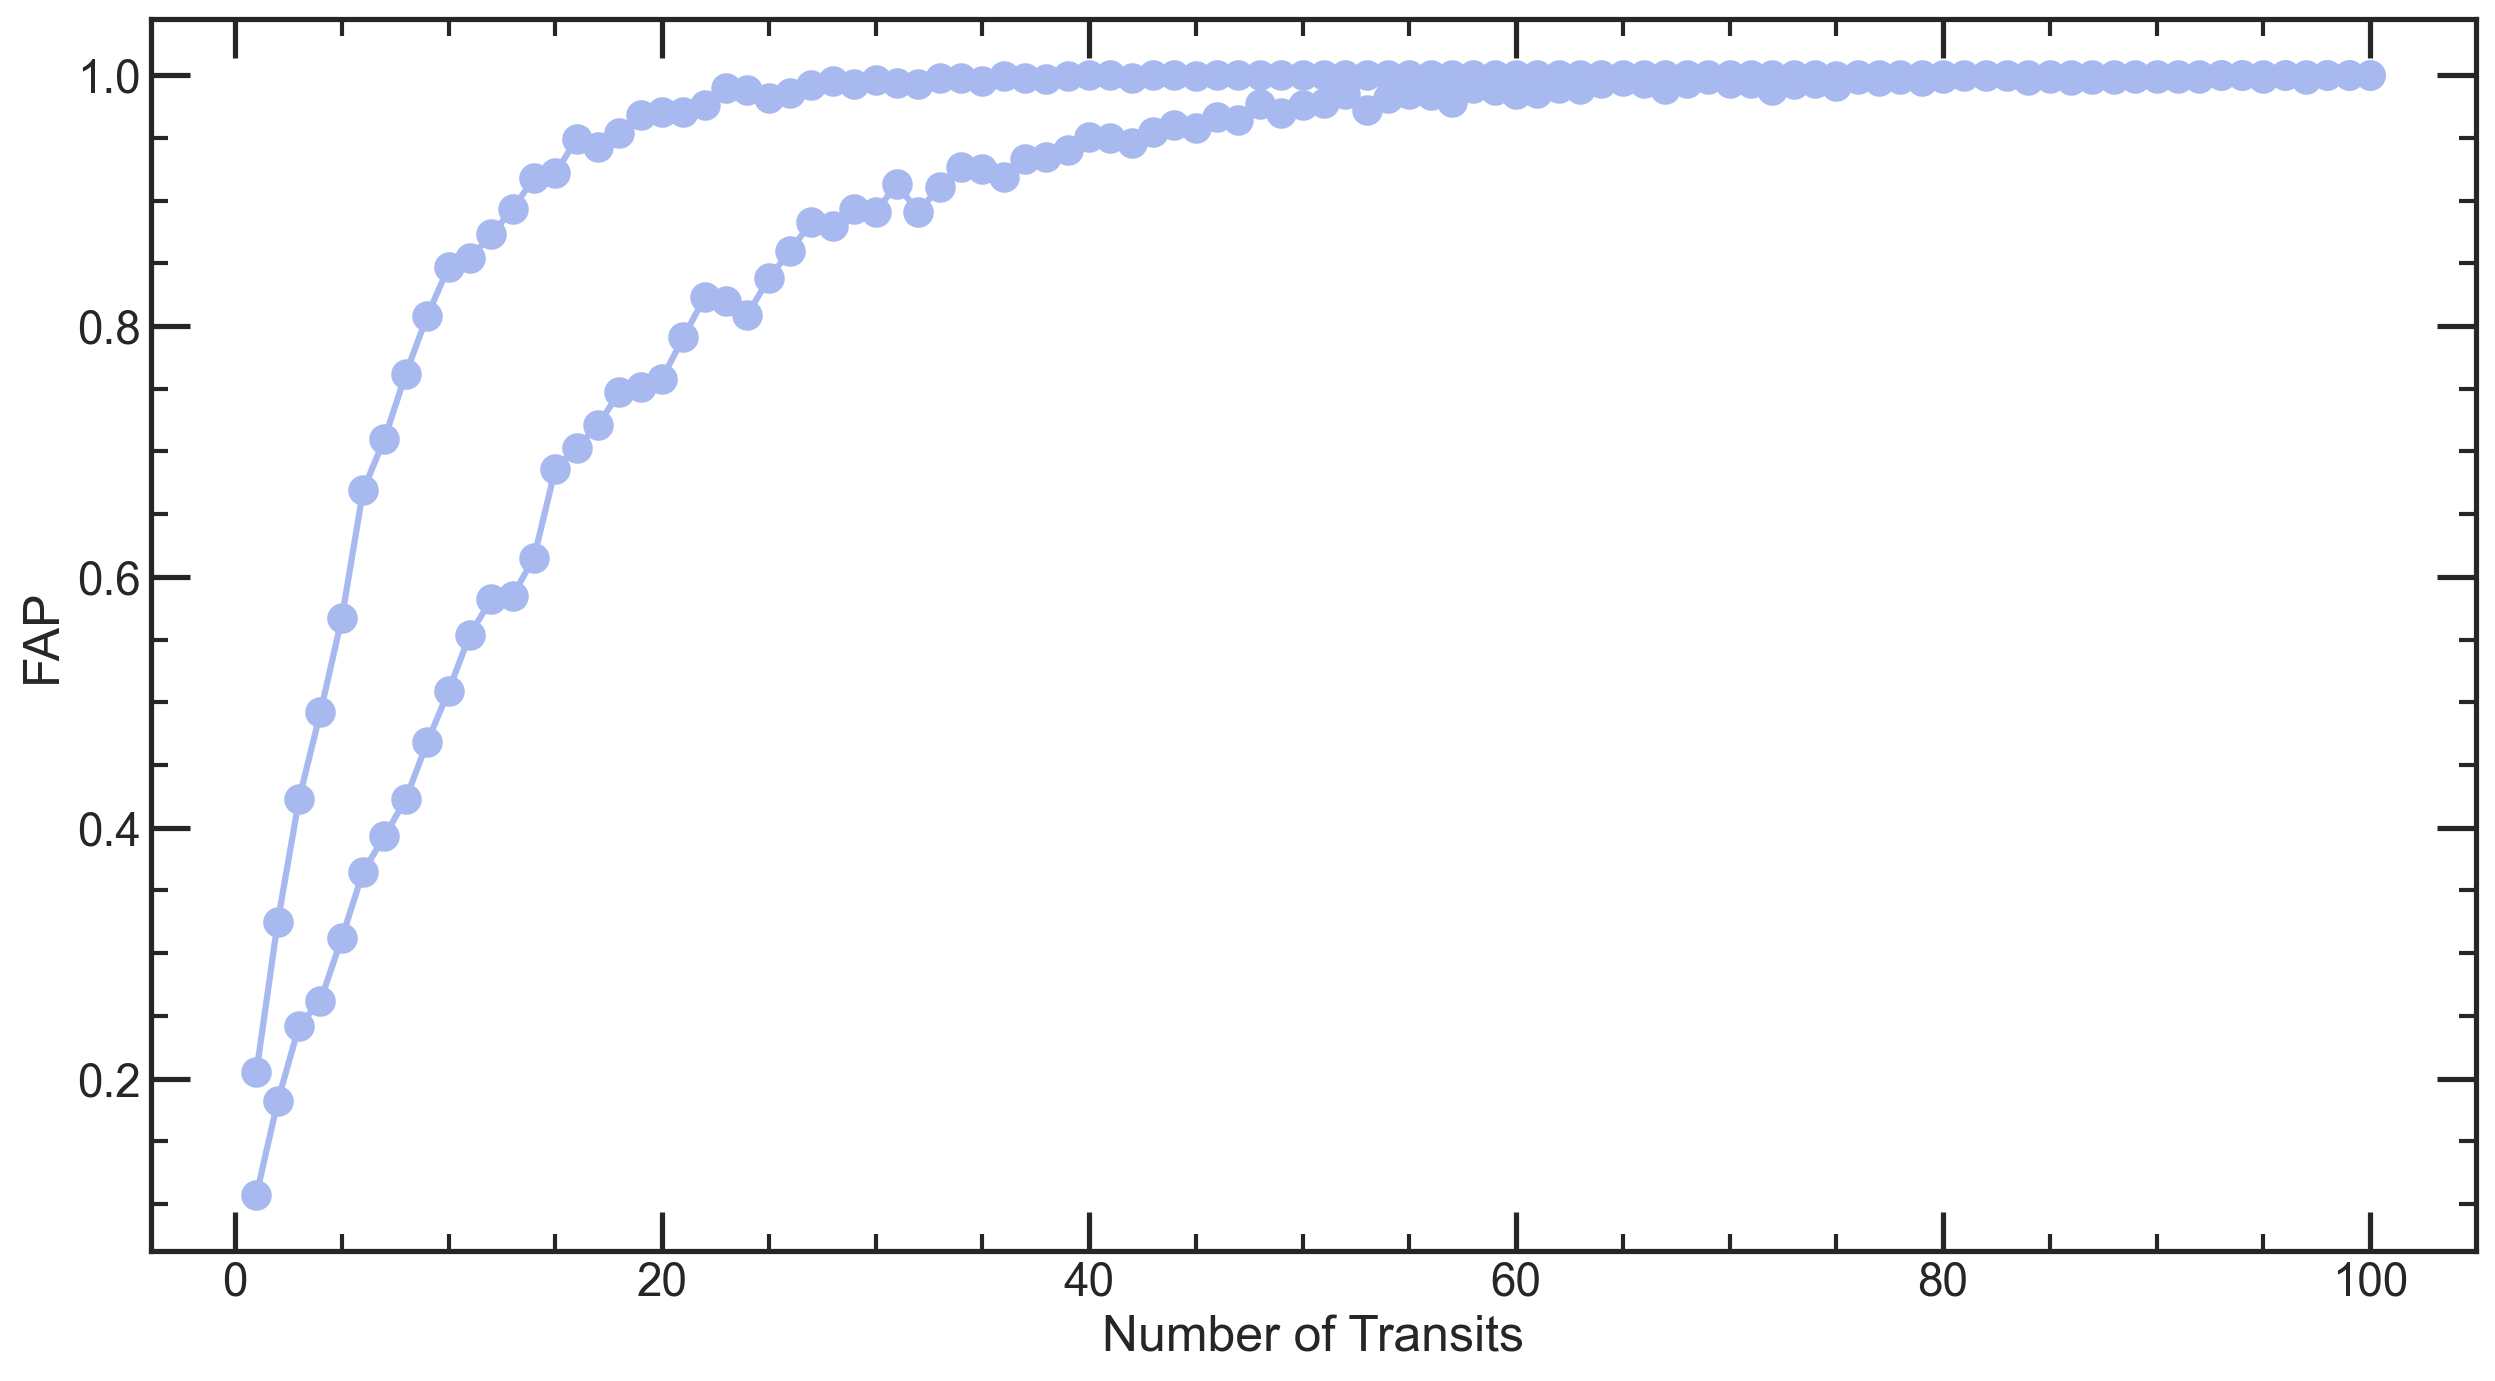

In [78]:
fig = plt.figure(figsize = (15, 8))
plt.plot(N_transits, fast_faps2, marker = 'o', ms = 10, color = '#A8B9F0')
plt.plot(N_transits, faps, marker = 'o', ms = 10, color = '#A8B9F0')
plt.ylabel('FAP')
plt.xlabel('Number of Transits')

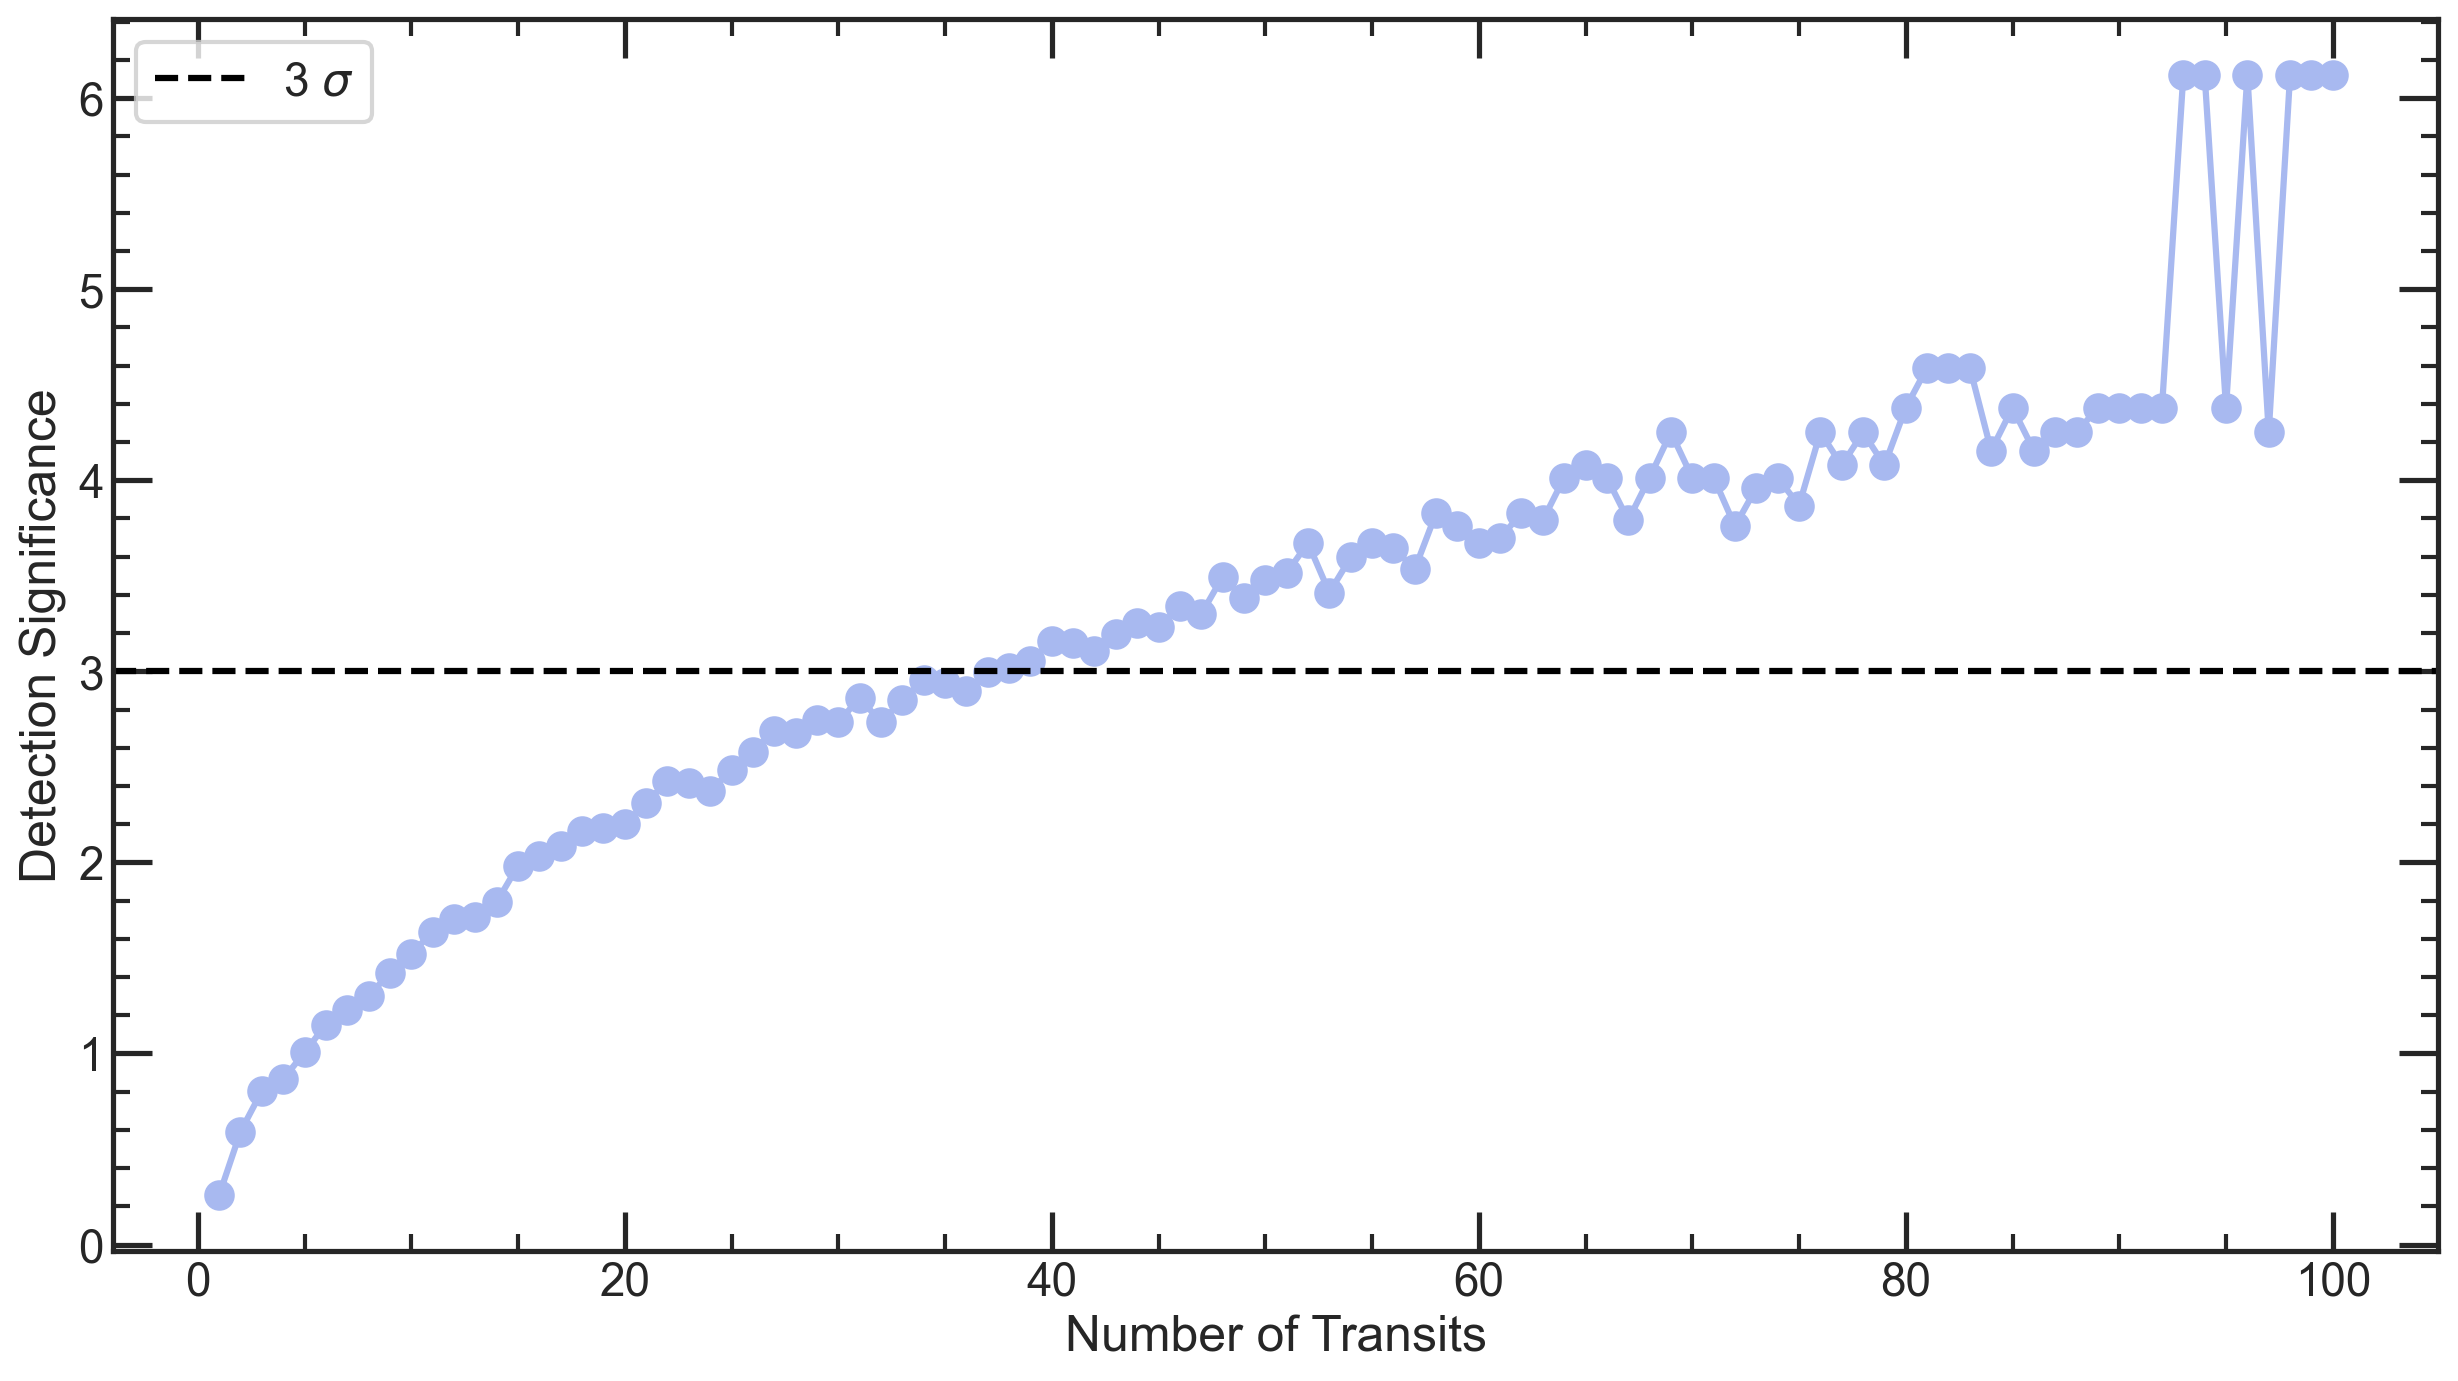

In [79]:
signif = np.array(fast_faps2) * 100 # Converting to percentage

# Convert significance to to sigma
sigma = f(signif)

fig = plt.figure(figsize = (15, 8))
plt.plot(N_transits, sigma,  marker = 'o', ms = 10, color = '#A8B9F0')
plt.axhline(3, color = 'black', ls = '--', label = r'3 $\sigma$')
plt.xlabel('Number of Transits')
plt.ylabel('Detection Significance')
plt.legend()

## Whererver sigma r is, do 1.20 * sigma_w (optical) or infrared do 1.5 * sigma_w

- read all imaging papers (transit is just snellen, rlm 2014, and rlm 2019, look for snellen 2nd author 2018 (donovan?), miguel et al 2011 (for lava worlds) read dressing and charb (transit probabilities ~ radius of planet / period of planet, look up, can include likelihood statistics for imaging vs transit here), want transits though because we're not technologically there yet for imaging. We're not necessarily only focusing on planets in the habitable zone (case for K and G dwarfs, lava worlds as an example where molecular oxygen might be escaping).)   
- write proposal   
- learn etc

In [56]:
# N_transits =  np.linspace(1, 100, 100, dtype = int).tolist() # Number of transits: 10 different values from 10 to 30
N_transits = 10 # (just do for 10 transits for now)
M = 1000 # Number of datales to make for each transit
N_photons = 1e8
system_v = 20 
delta_v = 0.5 # Change in velocity (the increment when dataling doppler shift)
CCF_vals = []


# Add noise
N_photons_total = N_transits*N_photons
sigma_w = 1/np.sqrt(N_photons_total)
sigma_r = 1.20*sigma_w  
noise = np.sqrt((sigma_w)**2 + (sigma_r)**2)

w_noise_only = np.random.uniform(low = -1, high = 1, size = data['F_star_planet'].size) * sigma_w
r_noise_only = np.random.uniform(low = -1, high = 1, size = data['F_star_planet'].size) * sigma_r
total_noise = np.random.uniform(low = -1, high = 1, size = data['F_star_planet'].size) * noise


sigma_ws.append(sigma_w)
sigma_rs.append(sigma_r)
noises.append(noise)


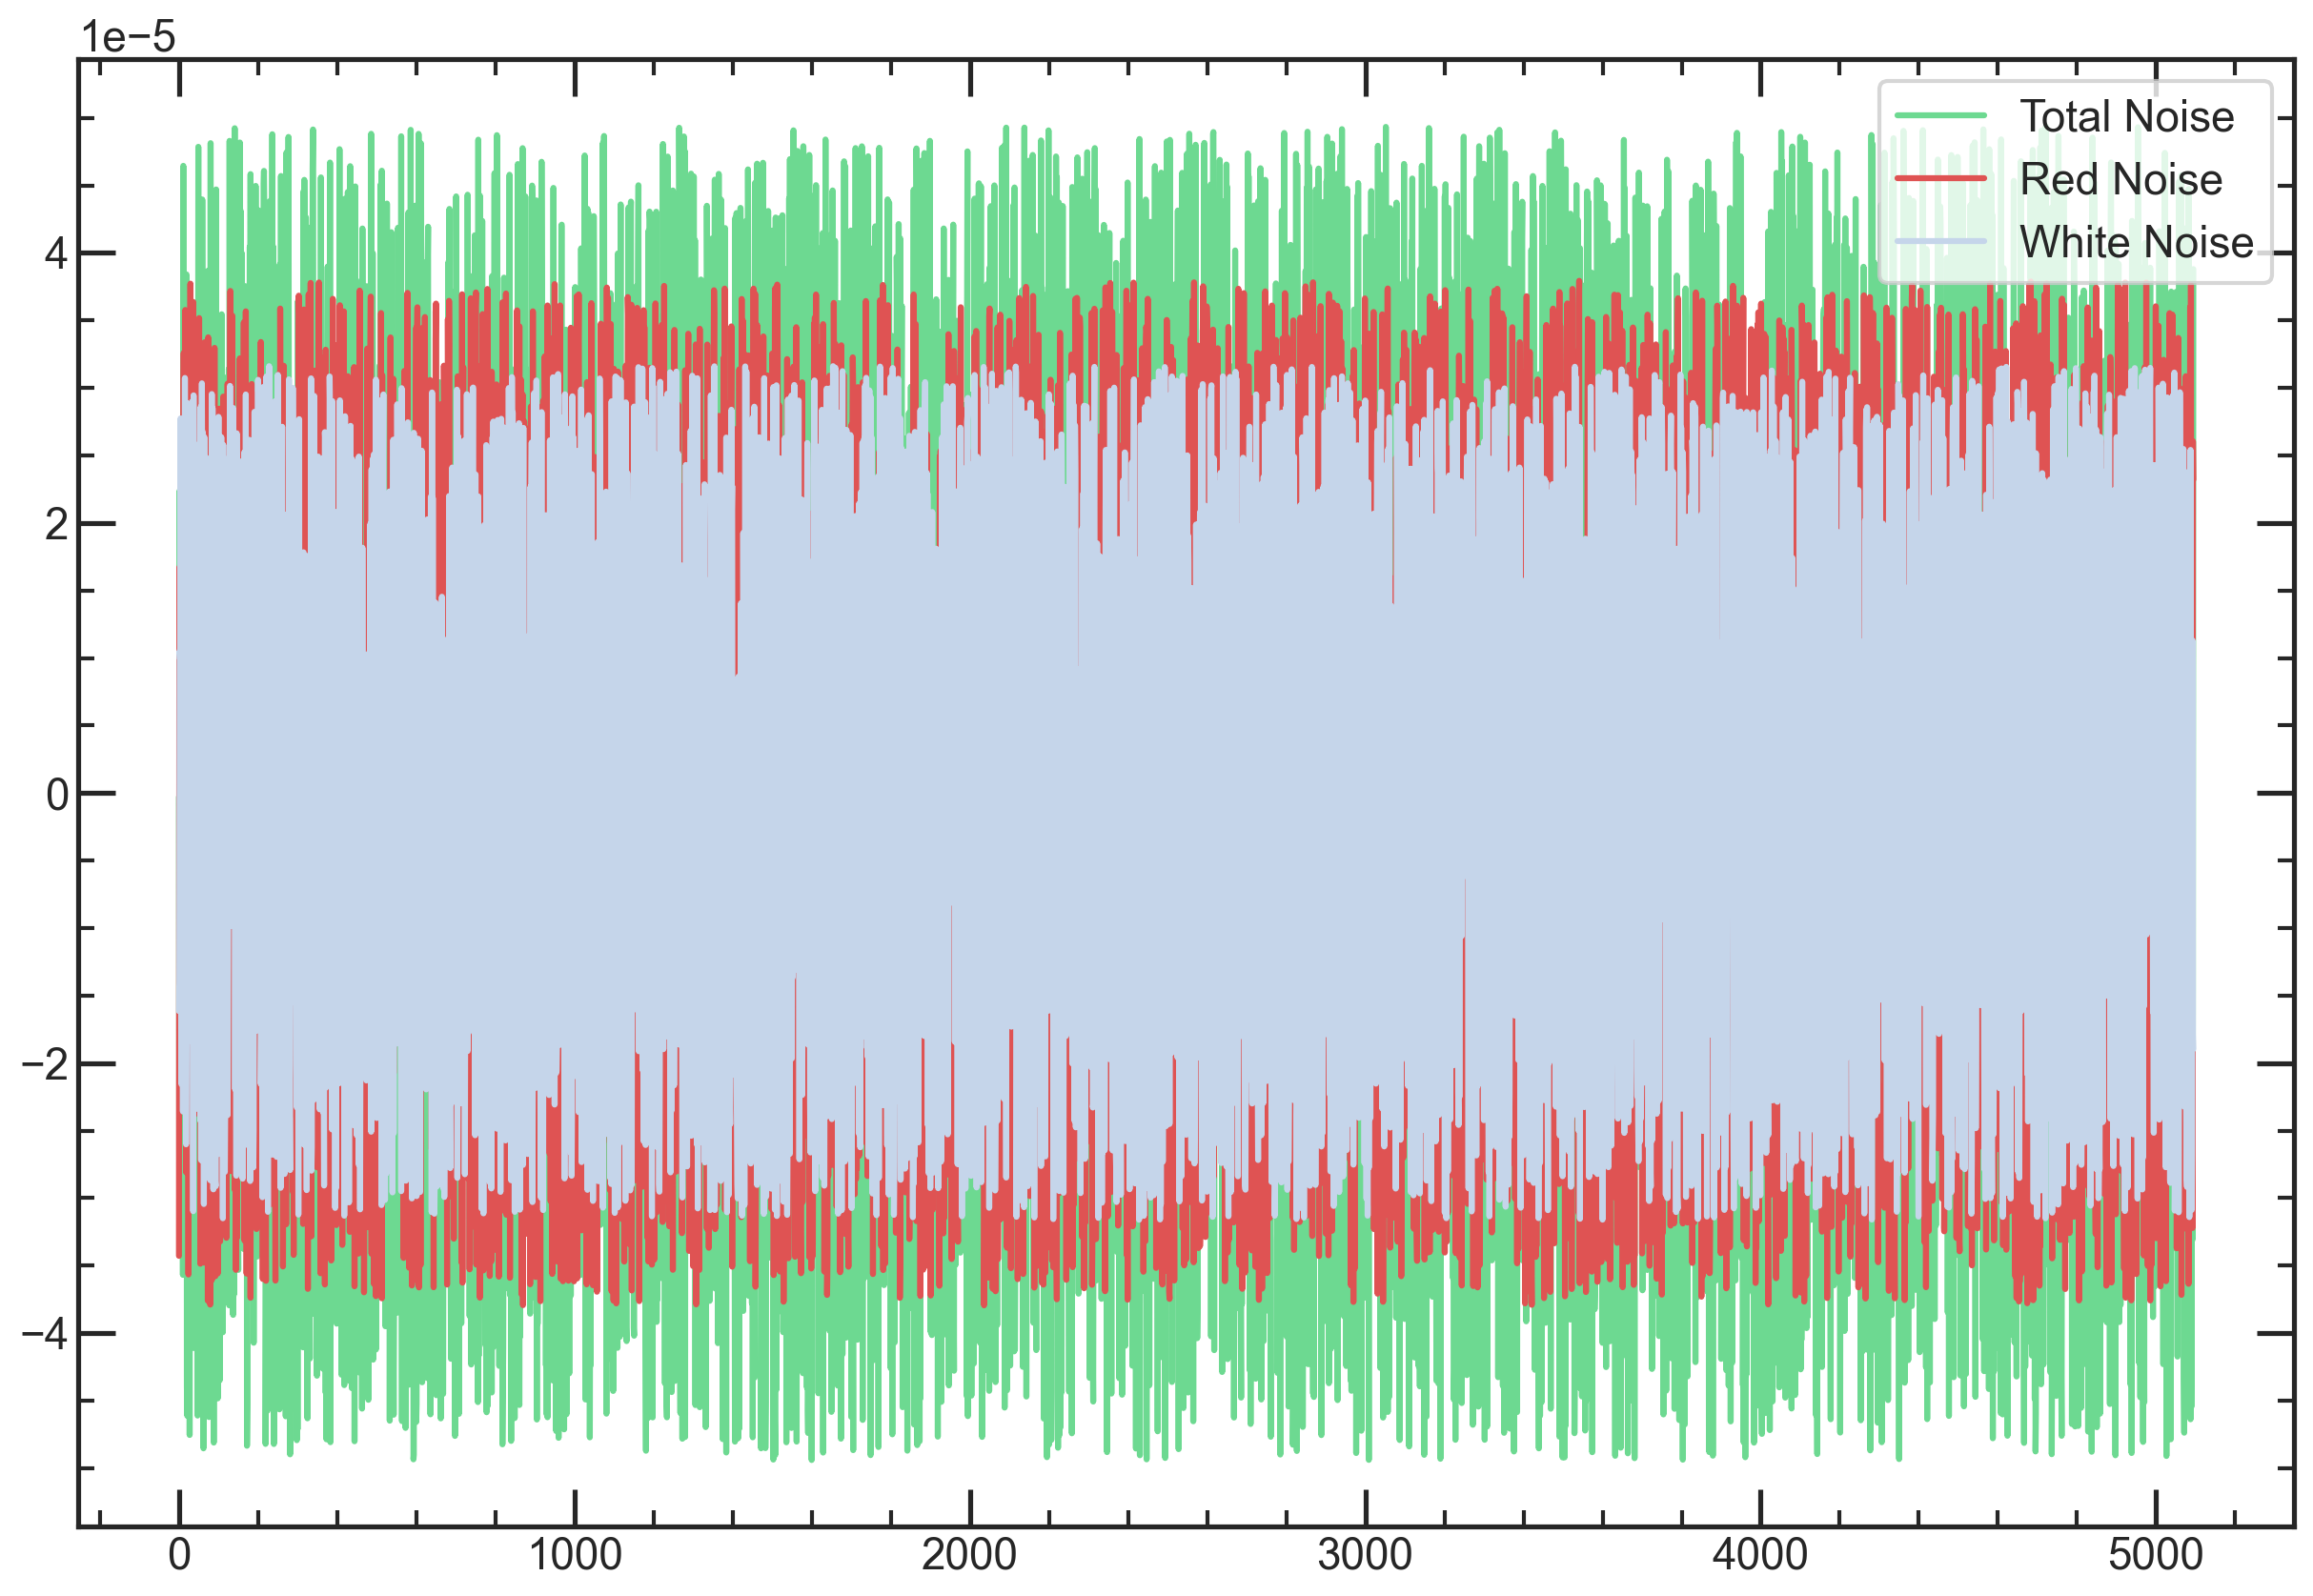

In [75]:
plt.figure(figsize = (15,10))
plt.plot(total_noise, color = '#6DD991', label = 'Total Noise')
plt.plot(r_noise_only, color = '#DF5353', label = 'Red Noise')
plt.plot(w_noise_only, color = '#C5D5EA', label = 'White Noise')
plt.legend()

Text(0.5, 0, 'Number of Transits')

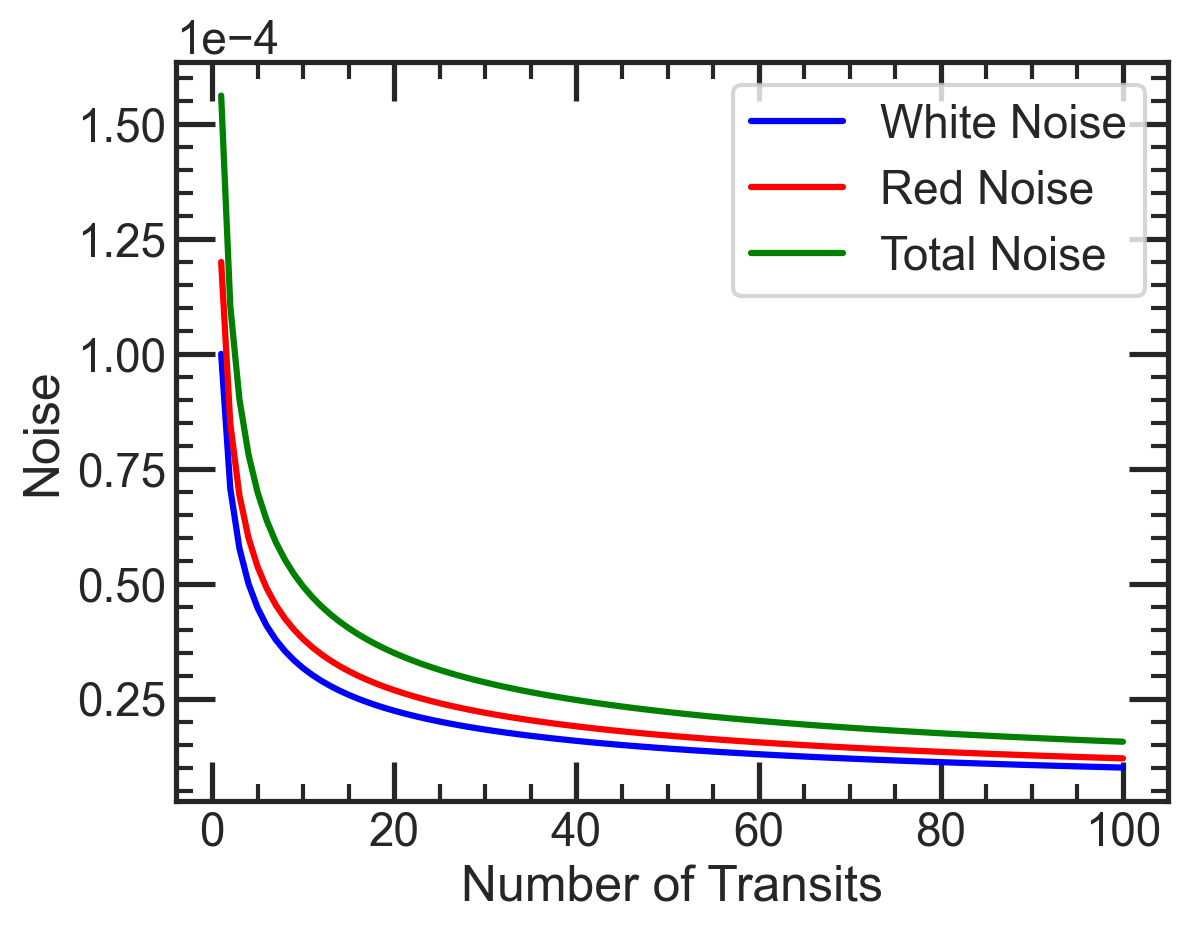

In [53]:
plt.plot(N_transits, sigma_ws, label = 'White Noise', color = 'Blue')
plt.plot(N_transits, sigma_rs, label = 'Red Noise', color = 'Red')
plt.plot(N_transits, noises, label = 'Total Noise', color = 'Green')
plt.legend()
plt.ylabel('Noise')
plt.xlabel('Number of Transits')